In this project, the data consists of house selling prices along with various house features. The goal is to build a machine learning model that accurately predicts these prices.

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn import metrics
!pip install optuna
import optuna
from sklearn.model_selection import cross_val_score

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 25.2 MB/s eta 0:00:00


In [ ]:
# Reading the data (df)
df = pd.read_csv("train.csv")

In [ ]:
# Removing "Id" coloumn because it not needed in training model
df = df.drop('Id', axis=1)

# pd.set_option('display.max_columns', None) # Unlock to reveal full columns
df.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


# Data Preprocessing

### Splitting data train and data validation

In [ ]:
columns = list(df.columns)

# Pick every feature except "SalePrice" as predictor
predictor = columns[:-1]
X = df[predictor]

# Pick "SalePrice" as target ("SalePrice" column is on the last column in the df)
target = columns[-1]
y = df[target]

In [ ]:
# Splitting train data (70%) and test data (30%)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print("Train size :", X_train.shape)
print("Test size :", X_test.shape)

Train size : (1022, 79)
Test size : (438, 79)


### Duplicats Handling

In [ ]:
len(df) - len(df.drop_duplicates())

0

In [ ]:
len(df.drop_duplicates()) / len(df)
#If it's not one, there are duplicats in the data

1.0

No duplicat on the data, therefore no need for duplicat handling

### Missing Value Handling

In [ ]:
# List all columns that have missing value
missing_columns = [column for column in df.columns if df[column].isna().sum() != 0]
missing_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [ ]:
def missing_percentage(column):
  return round(100 * len(df[df[column].isna()]) / len(df), 2)

# Check missing value percentage in missing columns
for column in missing_columns:
  print(f'Missing percentage in column {column} is {missing_percentage(column)}%')

Missing percentage in column LotFrontage is 17.74%
Missing percentage in column Alley is 93.77%
Missing percentage in column MasVnrType is 59.73%
Missing percentage in column MasVnrArea is 0.55%
Missing percentage in column BsmtQual is 2.53%
Missing percentage in column BsmtCond is 2.53%
Missing percentage in column BsmtExposure is 2.6%
Missing percentage in column BsmtFinType1 is 2.53%
Missing percentage in column BsmtFinType2 is 2.6%
Missing percentage in column Electrical is 0.07%
Missing percentage in column FireplaceQu is 47.26%
Missing percentage in column GarageType is 5.55%
Missing percentage in column GarageYrBlt is 5.55%
Missing percentage in column GarageFinish is 5.55%
Missing percentage in column GarageQual is 5.55%
Missing percentage in column GarageCond is 5.55%
Missing percentage in column PoolQC is 99.52%
Missing percentage in column Fence is 80.75%
Missing percentage in column MiscFeature is 96.3%


In [ ]:
# Drop columns that have greater than 20% missing value
X_train = X_train.drop(columns = [column for column in missing_columns if missing_percentage(column) > 20])
X_test = X_test.drop(columns = [column for column in missing_columns if missing_percentage(column) > 20])

In [ ]:
# Filter out columns with missing percentage greater than 20%
missing_columns = [column for column in missing_columns if missing_percentage(column) <= 20]

In [ ]:
# Checking datatype for missing columns
for column in missing_columns:
  print(f'Datatype in {column} is {df[column].dtype}')

Datatype in LotFrontage is float64
Datatype in MasVnrArea is float64
Datatype in BsmtQual is object
Datatype in BsmtCond is object
Datatype in BsmtExposure is object
Datatype in BsmtFinType1 is object
Datatype in BsmtFinType2 is object
Datatype in Electrical is object
Datatype in GarageType is object
Datatype in GarageYrBlt is float64
Datatype in GarageFinish is object
Datatype in GarageQual is object
Datatype in GarageCond is object


Missing value handling:
- If it's numerical data, then replace missing value with median
- If it's categorical data, then replace missing value with mode

In [ ]:
for column in missing_columns:
  # Handling int or float type columns
  if df[column].dtype == float or df[column].dtype == int:
    # Searching the column median
    train_median = X_train[~X_train[column].isna()][column].median()
    print(f'Column {column} train median is {train_median}')

    # Replace missing value with median
    X_train[column].fillna(train_median, inplace=True)
    X_test[column].fillna(train_median, inplace=True)
    print(f'Replaced {column} missing value with median')

  # Handling categorical type columns
  else:
    # Searching the column mode
    train_mode = X_train[~X_train[column].isna()][column].mode()[0]
    print(f'Column {column} train mode is {train_mode}')

    # Replace missing value with mode
    X_train[column].fillna(train_mode, inplace=True)
    X_test[column].fillna(train_mode, inplace=True)
    print(f'Replaced {column} missing value with mode')

  print()

Column LotFrontage train median is 68.0
Replaced LotFrontage missing value with median

Column MasVnrArea train median is 0.0
Replaced MasVnrArea missing value with median

Column BsmtQual train mode is TA
Replaced BsmtQual missing value with mode

Column BsmtCond train mode is TA
Replaced BsmtCond missing value with mode

Column BsmtExposure train mode is No
Replaced BsmtExposure missing value with mode

Column BsmtFinType1 train mode is Unf
Replaced BsmtFinType1 missing value with mode

Column BsmtFinType2 train mode is Unf
Replaced BsmtFinType2 missing value with mode

Column Electrical train mode is SBrkr
Replaced Electrical missing value with mode

Column GarageType train mode is Attchd
Replaced GarageType missing value with mode

Column GarageYrBlt train median is 1979.0
Replaced GarageYrBlt missing value with median

Column GarageFinish train mode is Unf
Replaced GarageFinish missing value with mode

Column GarageQual train mode is TA
Replaced GarageQual missing value with mode


<ipython-input-13-2549160728>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train[column].fillna(train_median, inplace=True)
<ipython-input-13-2549160728>:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using

### Encoding

In [ ]:
# List all custom columns that have categorical data
custom_columns = [column for column in X_train.columns if X_train[column].dtype == object]
print(custom_columns)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [ ]:
# Print all costum columns value to determine what kind of categorical data it is (Ordinal or Nominal)
for column in custom_columns:
    print(f"============= {column} =================")
    display(X_train[column].value_counts())
    print()

============= MSZoning =================


,count
MSZoning,
RL,795
RM,162
FV,41
RH,14
C (all),10



============= Street =================


,count
Street,
Pave,1017
Grvl,5



============= LotShape =================


,count
LotShape,
Reg,665
IR1,319
IR2,30
IR3,8



============= LandContour =================


,count
LandContour,
Lvl,913
Bnk,51
HLS,36
Low,22



============= Utilities =================


,count
Utilities,
AllPub,1021
NoSeWa,1



============= LotConfig =================


,count
LotConfig,
Inside,746
Corner,189
CulDSac,51
FR2,34
FR3,2



============= LandSlope =================


,count
LandSlope,
Gtl,973
Mod,41
Sev,8



============= Neighborhood =================


,count
Neighborhood,
NAmes,147
CollgCr,102
OldTown,82
Edwards,65
Somerst,55
NWAmes,55
Gilbert,50
Sawyer,50
SawyerW,49



============= Condition1 =================


,count
Condition1,
Norm,877
Feedr,59
Artery,31
RRAn,22
PosN,13
RRAe,8
PosA,6
RRNn,4
RRNe,2



============= Condition2 =================


,count
Condition2,
Norm,1008
Feedr,5
Artery,2
PosN,2
RRNn,2
PosA,1
RRAe,1
RRAn,1



============= BldgType =================


,count
BldgType,
1Fam,846
TwnhsE,81
Duplex,42
Twnhs,33
2fmCon,20



============= HouseStyle =================


,count
HouseStyle,
1Story,512
2Story,312
1.5Fin,109
SLvl,46
SFoyer,21
1.5Unf,11
2.5Fin,6
2.5Unf,5



============= RoofStyle =================


,count
RoofStyle,
Gable,799
Hip,198
Gambrel,11
Flat,7
Mansard,6
Shed,1



============= RoofMatl =================


,count
RoofMatl,
CompShg,1006
Tar&Grv,5
WdShngl,5
WdShake,3
Roll,1
ClyTile,1
Membran,1



============= Exterior1st =================


,count
Exterior1st,
VinylSd,357
Wd Sdng,156
MetalSd,152
HdBoard,150
Plywood,74
CemntBd,41
BrkFace,39
WdShing,20
Stucco,19



============= Exterior2nd =================


,count
Exterior2nd,
VinylSd,352
Wd Sdng,151
MetalSd,146
HdBoard,141
Plywood,96
CmentBd,41
Wd Shng,26
Stucco,21
BrkFace,19



============= ExterQual =================


,count
ExterQual,
TA,635
Gd,332
Ex,43
Fa,12



============= ExterCond =================


,count
ExterCond,
TA,901
Gd,100
Fa,18
Ex,2
Po,1



============= Foundation =================


,count
Foundation,
CBlock,443
PConc,440
BrkTil,114
Slab,19
Stone,4
Wood,2



============= BsmtQual =================


,count
BsmtQual,
TA,484
Gd,420
Ex,88
Fa,30



============= BsmtCond =================


,count
BsmtCond,
TA,943
Gd,44
Fa,33
Po,2



============= BsmtExposure =================


,count
BsmtExposure,
No,710
Av,146
Gd,89
Mn,77



============= BsmtFinType1 =================


,count
BsmtFinType1,
Unf,331
GLQ,288
ALQ,156
BLQ,105
Rec,87
LwQ,55



============= BsmtFinType2 =================


,count
BsmtFinType2,
Unf,910
Rec,42
LwQ,26
BLQ,21
ALQ,13
GLQ,10



============= Heating =================


,count
Heating,
GasA,1003
GasW,11
Wall,3
Grav,3
OthW,2



============= HeatingQC =================


,count
HeatingQC,
Ex,518
TA,297
Gd,172
Fa,34
Po,1



============= CentralAir =================


,count
CentralAir,
Y,953
N,69



============= Electrical =================


,count
Electrical,
SBrkr,929
FuseA,69
FuseF,21
FuseP,2
Mix,1



============= KitchenQual =================


,count
KitchenQual,
TA,521
Gd,412
Ex,63
Fa,26



============= Functional =================


,count
Functional,
Typ,949
Min2,28
Min1,21
Mod,10
Maj1,10
Maj2,4



============= GarageType =================


,count
GarageType,
Attchd,661
Detchd,280
BuiltIn,56
Basment,14
CarPort,8
2Types,3



============= GarageFinish =================


,count
GarageFinish,
Unf,493
RFn,282
Fin,247



============= GarageQual =================


,count
GarageQual,
TA,969
Fa,38
Gd,12
Po,2
Ex,1



============= GarageCond =================


,count
GarageCond,
TA,985
Fa,25
Gd,7
Po,4
Ex,1



============= PavedDrive =================


,count
PavedDrive,
Y,928
N,71
P,23



============= SaleType =================


,count
SaleType,
WD,883
New,84
COD,33
ConLD,6
ConLI,4
CWD,4
ConLw,3
Oth,3
Con,2



============= SaleCondition =================


,count
SaleCondition,
Normal,835
Partial,87
Abnorml,77
Family,12
Alloca,8
AdjLand,3


In [ ]:
# List out the column based on what encoding suite for them
label_encod = ['LotShape', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive']
one_hot_encod = ['Street']
mean_encod = ['MSZoning','LandContour','LotConfig','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','Foundation','Heating','Electrical','GarageType','SaleType','SaleCondition']

#### One Hot Encoding

In [ ]:
# One Hot Encoding
X_train = pd.get_dummies(X_train, columns=one_hot_encod)
X_test = pd.get_dummies(X_test, columns=one_hot_encod)
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Street_Grvl,Street_Pave
376,85,RL,57.0,8846,IR1,Lvl,AllPub,CulDSac,Gtl,CollgCr,...,0,0,0,0,7,2006,WD,Normal,False,True
250,30,RL,55.0,5350,IR1,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,450,5,2010,WD,Normal,False,True
228,20,RL,70.0,8521,Reg,Lvl,AllPub,FR2,Gtl,Sawyer,...,0,0,0,0,5,2010,WD,Normal,False,True
40,20,RL,84.0,8658,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,0,0,0,0,12,2006,WD,Abnorml,False,True
428,20,RL,64.0,6762,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,9,2007,New,Partial,False,True


#### Label Encoding

In [ ]:
# Encoding LotShape
# Define own mapping
mapping = {'Reg': 0, 'IR1': 1, 'IR2': 2, 'IR3': 3}

# Apply the mapping to the 'LotShape' column in the train and test set
X_train['LotShape'] = X_train['LotShape'].map(mapping)
X_test['LotShape'] = X_test['LotShape'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['LotShape'] = X_test['LotShape'].fillna(-1).astype(int)

In [ ]:
# Encoding Utilities
# Define own mapping
mapping = {'NoSeWa': 0, 'AllPub': 1}

# Apply the mapping to the 'Utilities' column in the train and test set
X_train['Utilities'] = X_train['Utilities'].map(mapping)
X_test['Utilities'] = X_test['Utilities'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['Utilities'] = X_test['Utilities'].fillna(-1).astype(int)

In [ ]:
# Encoding LandSlope
# Define own mapping
mapping = {'Gtl': 0, 'Mod': 1, 'Sev': 2}

# Apply the mapping to the 'LandSlope' column in the train and test set
X_train['LandSlope'] = X_train['LandSlope'].map(mapping)
X_test['LandSlope'] = X_test['LandSlope'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['LandSlope'] = X_test['LandSlope'].fillna(-1).astype(int)

In [ ]:
# Define own mapping
mapping = {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}

# List Columns that use the same mapping
columns_list = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']

# Apply the mapping to the column in the train and test set
for column in columns_list:
  X_train[column] = X_train[column].map(mapping)
  X_test[column] = X_test[column].map(mapping)
  # Handle unseen categories (e.g., assign a default value like -1)
  X_test[column] = X_test[column].fillna(-1).astype(int)

In [ ]:
# Define own mapping
mapping = {'Unf': 0, 'Rec': 1, 'LwQ': 2, 'BLQ': 3, 'ALQ': 4, 'GLQ': 5}

# List Columns that use the same mapping
columns_list = ['BsmtFinType1', 'BsmtFinType2']

# Apply the mapping to the column in the train and test set
for column in columns_list:
  X_train[column] = X_train[column].map(mapping)
  X_test[column] = X_test[column].map(mapping)
  # Handle unseen categories (e.g., assign a default value like -1)
  X_test[column] = X_test[column].fillna(-1).astype(int)

In [ ]:
# Encoding BsmtExposure
# Define own mapping
mapping = {'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}

# Apply the mapping to the 'BsmtExposure' column in the train and test set
X_train['BsmtExposure'] = X_train['BsmtExposure'].map(mapping)
X_test['BsmtExposure'] = X_test['BsmtExposure'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['BsmtExposure'] = X_test['BsmtExposure'].fillna(-1).astype(int)

In [ ]:
# Encoding CentralAir
# Define own mapping
mapping = {'N': 0, 'Y': 1}

# Apply the mapping to the 'CentralAir' column in the train and test set
X_train['CentralAir'] = X_train['CentralAir'].map(mapping)
X_test['CentralAir'] = X_test['CentralAir'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['CentralAir'] = X_test['CentralAir'].fillna(-1).astype(int)

In [ ]:
# Encoding Functional
# Define own mapping
mapping = {'Typ': 0, 'Min2': 1, 'Min1': 2, 'Mod': 3, 'Maj1': 4, 'Maj2':5}

# Apply the mapping to the 'Functional' column in the train and test set
X_train['Functional'] = X_train['Functional'].map(mapping)
X_test['Functional'] = X_test['Functional'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['Functional'] = X_test['Functional'].fillna(-1).astype(int)

In [ ]:
# Encoding GarageFinish
# Define own mapping
mapping = {'Unf': 0, 'RFn': 1, 'Fin': 2}

# Apply the mapping to the 'GarageFinish' column in the train and test set
X_train['GarageFinish'] = X_train['GarageFinish'].map(mapping)
X_test['GarageFinish'] = X_test['GarageFinish'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['GarageFinish'] = X_test['GarageFinish'].fillna(-1).astype(int)

In [ ]:
# Encoding PavedDrive
# Define own mapping
mapping = {'N': 0, 'P': 1, 'Y': 2}

# Apply the mapping to the 'PavedDrive' column in the train and test set
X_train['PavedDrive'] = X_train['PavedDrive'].map(mapping)
X_test['PavedDrive'] = X_test['PavedDrive'].map(mapping)

# Handle unseen categories (e.g., assign a default value like -1)
X_test['PavedDrive'] = X_test['PavedDrive'].fillna(-1).astype(int)

#### Mean Encoding

In [ ]:
# Compute mean of target value for each category in the training set
mean_encoding = X_train.copy()
mean_encoding['SalePrice'] = y_train

for column in mean_encod:
  # Calculate mean target value for each category
  mean_encoding_dict = mean_encoding.groupby(column)['SalePrice'].mean().to_dict()
  print(f'========{column}========')
  print(mean_encoding_dict)

  # Map the mean values to the original data
  X_train[column] = X_train[column].map(mean_encoding_dict)
  X_test[column] = X_test[column].map(mean_encoding_dict)
  # Handle unseen categories (e.g., assign a default value like -1)
  X_test[column] = X_test[column].fillna(-1).astype(int)
  print('Mean encoding suscessed!\n')

========MSZoning========
{'C (all)': 74528.0, 'FV': 209801.8536585366, 'RH': 130852.42857142857, 'RL': 191876.81635220125, 'RM': 124978.82098765433}
Mean encoding suscessed!

========LandContour========
{'Bnk': 144450.23529411765, 'HLS': 250816.58333333334, 'Low': 194400.0, 'Lvl': 178854.9496166484}
Mean encoding suscessed!

========LotConfig========
{'Corner': 182284.4656084656, 'CulDSac': 227960.45098039217, 'FR2': 176497.79411764705, 'FR3': 167500.0, 'Inside': 176345.91957104558}
Mean encoding suscessed!

========Neighborhood========
{'Blmngtn': 197076.25, 'Blueste': 124000.0, 'BrDale': 104600.0, 'BrkSide': 124584.375, 'ClearCr': 199143.0588235294, 'CollgCr': 196105.9019607843, 'Crawfor': 210078.9512195122, 'Edwards': 132723.38461538462, 'Gilbert': 189811.92, 'IDOTRR': 98163.87096774194, 'MeadowV': 99737.5, 'Mitchel': 152574.5, 'NAmes': 144160.37414965985, 'NPkVill': 143031.25, 'NWAmes': 190706.45454545456, 'NoRidge': 353484.0, 'NridgHt': 333404.7708333333, 'OldTown': 126167.7926829

In [ ]:
# X_train after encoding:
X_train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Street_Grvl,Street_Pave
376,85,191876.816352,57.0,8846,1,178854.949617,1,227960.450980,0,196105.901961,...,0,0,0,0,7,2006,172344.773499,174460.821557,False,True
250,30,191876.816352,55.0,5350,1,178854.949617,1,176345.919571,0,124584.375000,...,0,0,0,450,5,2010,172344.773499,174460.821557,False,True
228,20,191876.816352,70.0,8521,0,178854.949617,1,176497.794118,0,135348.840000,...,0,0,0,0,5,2010,172344.773499,174460.821557,False,True


### Standar Scalling

In [ ]:
# Number of unique values to consider "discrete"
discrete_threshold = 20 # If unique value < than 20, it count as discrete value, else continuous

continuous_cols = []
discrete_cols = []

for col in X_train.select_dtypes(include=['int64', 'float64']).columns:
    unique_vals = df[col].nunique()

    if unique_vals <= discrete_threshold:
        discrete_cols.append(col)
    else:
        continuous_cols.append(col)

print("Continuous columns:")
print(continuous_cols)

print("\nDiscrete columns:")
print(discrete_cols)

Continuous columns:
['LotFrontage', 'LotArea', 'Neighborhood', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch', 'MiscVal']

Discrete columns:
['MSSubClass', 'MSZoning', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'PoolArea', 'MoSold', '

In [ ]:
from sklearn.preprocessing import StandardScaler

# Inisialisasi StandardScaler
scaler = StandardScaler()

In [ ]:
# Make a copy of the standarize continuous data
X_train_std = scaler.fit_transform(X_train[continuous_cols])
X_test_std = scaler.transform(X_test[continuous_cols])

X_train_std = pd.DataFrame(X_train_std, columns=continuous_cols, index=X_train.index)
X_test_std = pd.DataFrame(X_test_std, columns=continuous_cols, index=X_test.index)

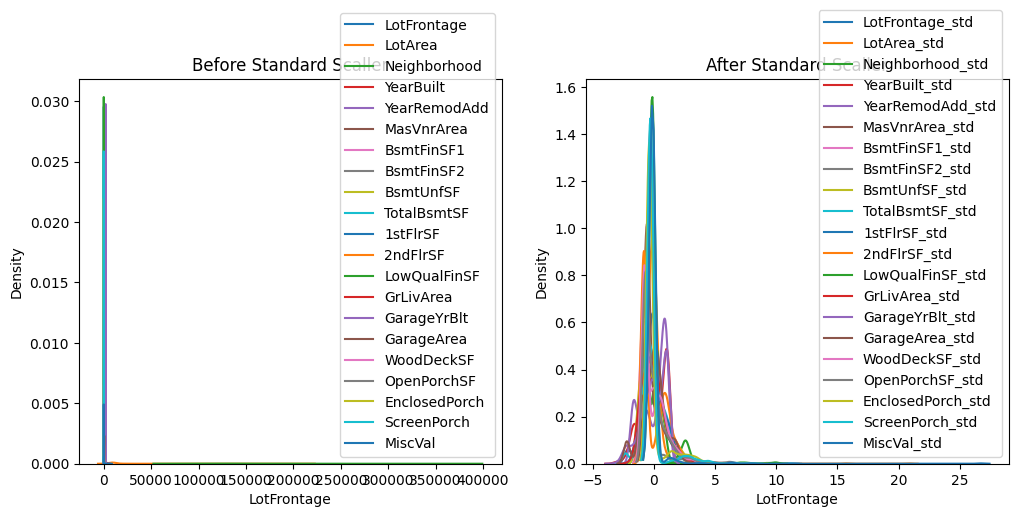

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 5))

# Distribution plot before standar scalling
ax1.set_title('Before Standard Scaller')
for column in continuous_cols:
  sns.kdeplot(X_train[column], ax=ax1, label=column)


# Distribution plot after standar scalling
ax2.set_title('After Standard Scaller')
for column in continuous_cols:
  sns.kdeplot(X_train_std[column], ax=ax2, label=f'{column}_std')

ax1.legend()
ax2.legend()

plt.show()

In [ ]:
# Statisticly change mean close to 0 and std close to 1
X_train_std.describe()

,LotFrontage,LotArea,Neighborhood,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,2ndFlrSF,LowQualFinSF,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,ScreenPorch,MiscVal
count,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,...,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03,1.022000e+03
mean,1.564306e-16,-2.433366e-17,-1.407876e-16,-3.041707e-15,-2.838347e-15,-4.171484e-17,-6.952473e-18,2.954801e-17,-2.607177e-17,8.342968e-17,...,-1.042871e-17,4.606013e-17,-9.081668e-17,4.345296e-16,7.821532e-17,1.042871e-17,-4.866731e-17,-4.866731e-17,-1.390495e-17,4.171484e-17
std,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,...,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00,1.000490e+00
min,-2.226954e+00,-9.162177e-01,-1.342169e+00,-3.207183e+00,-1.687625e+00,-5.706672e-01,-9.322243e-01,-2.822895e-01,-1.279247e+00,-2.309285e+00,...,-7.978281e-01,-1.294004e-01,-2.199088e+00,-3.191872e+00,-2.190237e+00,-7.494212e-01,-6.855473e-01,-3.608028e-01,-2.710321e-01,-1.087542e-01
25%,-4.222994e-01,-2.888728e-01,-7.323664e-01,-6.273902e-01,-8.663601e-01,-5.706672e-01,-9.322243e-01,-2.822895e-01,-7.766266e-01,-6.007356e-01,...,-7.978281e-01,-1.294004e-01,-7.081608e-01,-6.506944e-01,-6.710332e-01,-7.494212e-01,-6.855473e-01,-3.608028e-01,-2.710321e-01,-1.087542e-01
50%,-5.211393e-02,-9.876056e-02,1.335785e-01,5.837748e-02,4.380016e-01,-5.706672e-01,-1.701715e-01,-2.822895e-01,-2.086427e-01,-1.407416e-01,...,-7.978281e-01,-1.294004e-01,-1.295160e-01,4.607999e-02,4.858971e-02,-7.494212e-01,-3.783346e-01,-3.608028e-01,-2.710321e-01,-1.087542e-01
75%,4.106179e-01,1.291203e-01,2.799125e-01,9.727344e-01,9.210985e-01,3.272420e-01,5.728300e-01,-2.822895e-01,5.199318e-01,5.459637e-01,...,8.718888e-01,-1.294004e-01,4.973879e-01,9.068013e-01,5.189314e-01,5.501053e-01,3.282547e-01,-3.608028e-01,-2.710321e-01,-1.087542e-01
max,1.128482e+01,2.080531e+01,2.844871e+00,1.299290e+00,1.210957e+00,5.924255e+00,1.101507e+01,8.706082e+00,3.985873e+00,1.107435e+01,...,3.948167e+00,1.016039e+01,7.653188e+00,1.316669e+00,4.479209e+00,5.879711e+00,7.716720e+00,8.529554e+00,8.187362e+00,2.667439e+01


In [ ]:
# Concatenate scaled continuous + unscaled remaining columns
X_train_std = pd.concat([X_train_std, X_train.drop(columns=continuous_cols)], axis=1)
X_test_std = pd.concat([X_test_std, X_test.drop(columns=continuous_cols)], axis=1)

# Change X_train and X_test to the scalled one
X_train = X_train_std
X_test = X_test_std

X_train.head(3)

,LotFrontage,LotArea,Neighborhood,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageCond,PavedDrive,3SsnPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,Street_Grvl,Street_Pave
376,-0.561119,-0.150083,0.264000,0.842112,0.534621,-0.570667,-0.301414,-0.28229,0.009986,-0.403595,...,2,2,0,0,7,2006,172344.773499,174460.821557,False,True
250,-0.653665,-0.505027,-0.908895,-0.986602,-0.914670,-0.570667,-0.932224,-0.28229,0.361595,-0.714639,...,2,2,0,0,5,2010,172344.773499,174460.821557,False,True
228,0.040432,-0.183080,-0.732366,-0.104901,-0.866360,-0.570667,0.850133,-0.28229,-1.121474,-0.311597,...,2,2,0,0,5,2010,172344.773499,174460.821557,False,True


### Target Variable Preprocessing (Log Transformation)

In [ ]:
# Recreate df with current preprocessed X_train and y_train
df = X_train.copy()
df["SalePrice"] = y_train

count      1022.000000
mean     180007.561644
std       80956.717637
min       34900.000000
25%      128962.500000
50%      160000.000000
75%      211000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-37-3558857412>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});


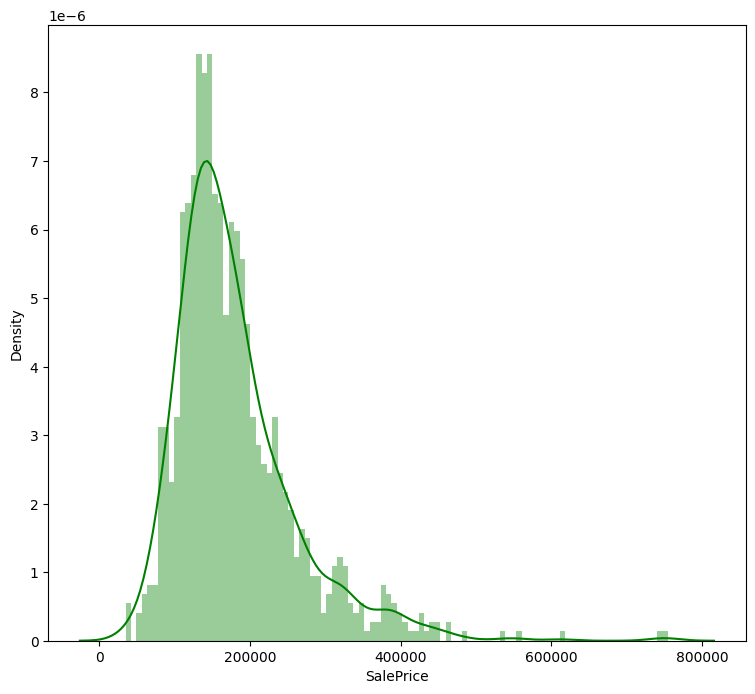

In [ ]:
# SalePrice statistics
print(df['SalePrice'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['SalePrice'], color='g', bins=100, hist_kws={'alpha': 0.4});

<Axes: xlabel='SalePrice', ylabel='Count'>

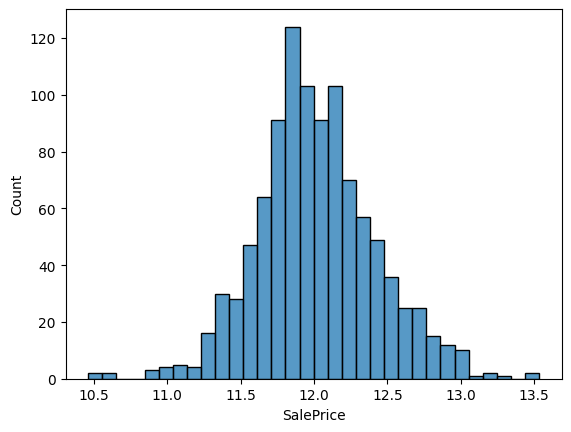

In [ ]:
# Histrogram SalePrice before shows data distribution of SalePrice which is right scew
# Using Log transformation will change it to normal distribution
sns.histplot(np.log1p(df["SalePrice"]))

In [ ]:
# Log Transform SalePrice in train and test
y_train = np.log(y_train)
y_test = np.log(y_test)

Log transformation also reduce the number of value in Sale Price. This is important because we face numpy error issue because of too many value.

### Feature Selection Using Correlation Analysis

In [ ]:
num_columns = X_train.shape[1]
print(f"Number of columns: {num_columns}")

Number of columns: 74


In [ ]:
# Recreate df with current preprocessed X_train and y_train
df = X_train.copy()
df["SalePrice"] = y_train

In [ ]:
# Find Correlation
df.corr()

,LotFrontage,LotArea,Neighborhood,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,PavedDrive,3SsnPorch,PoolArea,MoSold,YrSold,SaleType,SaleCondition,Street_Grvl,Street_Pave,SalePrice
LotFrontage,1.000000,0.349172,0.244259,0.126041,0.098050,0.216517,0.246430,0.063283,0.154678,0.428057,...,0.101213,0.063278,0.258062,-0.003546,0.014746,0.157866,0.162488,0.044365,-0.044365,0.357515
LotArea,0.349172,1.000000,0.160347,0.026058,-0.005240,0.081177,0.224743,0.160321,-0.011598,0.278878,...,0.005344,0.021971,0.116741,0.015010,0.004311,0.037749,0.047875,0.261058,-0.261058,0.253246
Neighborhood,0.244259,0.160347,1.000000,0.605423,0.470988,0.439433,0.268972,-0.039943,0.215800,0.473704,...,0.235035,0.037110,0.010475,0.067800,-0.026680,0.339665,0.335641,-0.029867,0.029867,0.743186
YearBuilt,0.126041,0.026058,0.605423,1.000000,0.567472,0.329323,0.256974,-0.029647,0.145337,0.396508,...,0.431803,0.039744,0.005359,0.001787,-0.022615,0.356360,0.365346,-0.033458,0.033458,0.583003
YearRemodAdd,0.098050,-0.005240,0.470988,0.567472,1.000000,0.173004,0.147865,-0.048704,0.156988,0.288081,...,0.174186,0.055867,0.002666,0.014398,0.035772,0.340081,0.346029,-0.089200,0.089200,0.542942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SaleType,0.157866,0.037749,0.339665,0.356360,0.340081,0.146970,0.098203,-0.086315,0.205082,0.269922,...,0.099572,0.042456,0.023256,0.058542,-0.102412,1.000000,0.913571,-0.028431,0.028431,0.343823
SaleCondition,0.162488,0.047875,0.335641,0.365346,0.346029,0.153622,0.091955,-0.077217,0.209835,0.271343,...,0.115799,0.046289,-0.001756,0.051870,-0.076487,0.913571,1.000000,-0.015639,0.015639,0.354219
Street_Grvl,0.044365,0.261058,-0.029867,-0.033458,-0.089200,-0.022420,0.009204,0.053663,-0.028063,0.001528,...,-0.031936,-0.007912,-0.004852,0.000730,0.039521,-0.028431,-0.015639,1.000000,-1.000000,-0.060553
Street_Pave,-0.044365,-0.261058,0.029867,0.033458,0.089200,0.022420,-0.009204,-0.053663,0.028063,-0.001528,...,0.031936,0.007912,0.004852,-0.000730,-0.039521,0.028431,0.015639,-1.000000,1.000000,0.060553


In [ ]:
# Correlation matrix is stored in a DataFrame called 'corr_matrix'
corr_matrix = df.corr()

# Extract correlations with the 'Price' variable
price_corr = corr_matrix['SalePrice']

# Filter for correlations based on how storng the corr is
strong_corr = price_corr[price_corr >= 0.7]
medium_corr = price_corr[(price_corr >= 0.5) & (price_corr < 0.7)]
low_corr = price_corr[(price_corr >= 0.3) & (price_corr < 0.5)]
negligible_corr = price_corr[price_corr < 0.3]

# Exclude the 'SalePrice' itself
strong_corr = strong_corr.drop('SalePrice')

print("Strong Correlation (>= 0.7):")
print(strong_corr)

print("\nMedium Correlation (0.5 <= corr < 0.7):")
print(medium_corr)

print("\nLow Correlation (0.3 <= corr < 0.5):")
print(low_corr)

print("\nNegligible Correlation (< 0.3):")
print(negligible_corr)

Strong Correlation (>= 0.7):
Neighborhood    0.743186
OverallQual     0.822385
Name: SalePrice, dtype: float64

Medium Correlation (0.5 <= corr < 0.7):
YearBuilt       0.583003
YearRemodAdd    0.542942
TotalBsmtSF     0.610164
1stFlrSF        0.607771
GrLivArea       0.689466
GarageArea      0.643074
ExterQual       0.679452
Foundation      0.553843
BsmtQual        0.661282
FullBath        0.599511
KitchenQual     0.652412
TotRmsAbvGrd    0.532889
GarageFinish    0.577639
GarageCars      0.670115
Name: SalePrice, dtype: float64

Low Correlation (0.3 <= corr < 0.5):
LotFrontage      0.357515
MasVnrArea       0.427911
BsmtFinSF1       0.381944
2ndFlrSF         0.303350
GarageYrBlt      0.480174
WoodDeckSF       0.311543
OpenPorchSF      0.318035
MSZoning         0.433057
LotShape         0.309870
Exterior1st      0.408247
Exterior2nd      0.402730
BsmtExposure     0.355731
BsmtFinType1     0.342488
HeatingQC        0.449046
CentralAir       0.355285
Electrical       0.315376
Fireplaces  

In [ ]:
# Get all column names from negligible_corr
negligible_corr_columns = negligible_corr.index.tolist()

# Drop Negligible columns from X_train and X_test
X_train = X_train.drop(columns=negligible_corr_columns)
X_test = X_test.drop(columns=negligible_corr_columns)

<Axes: >

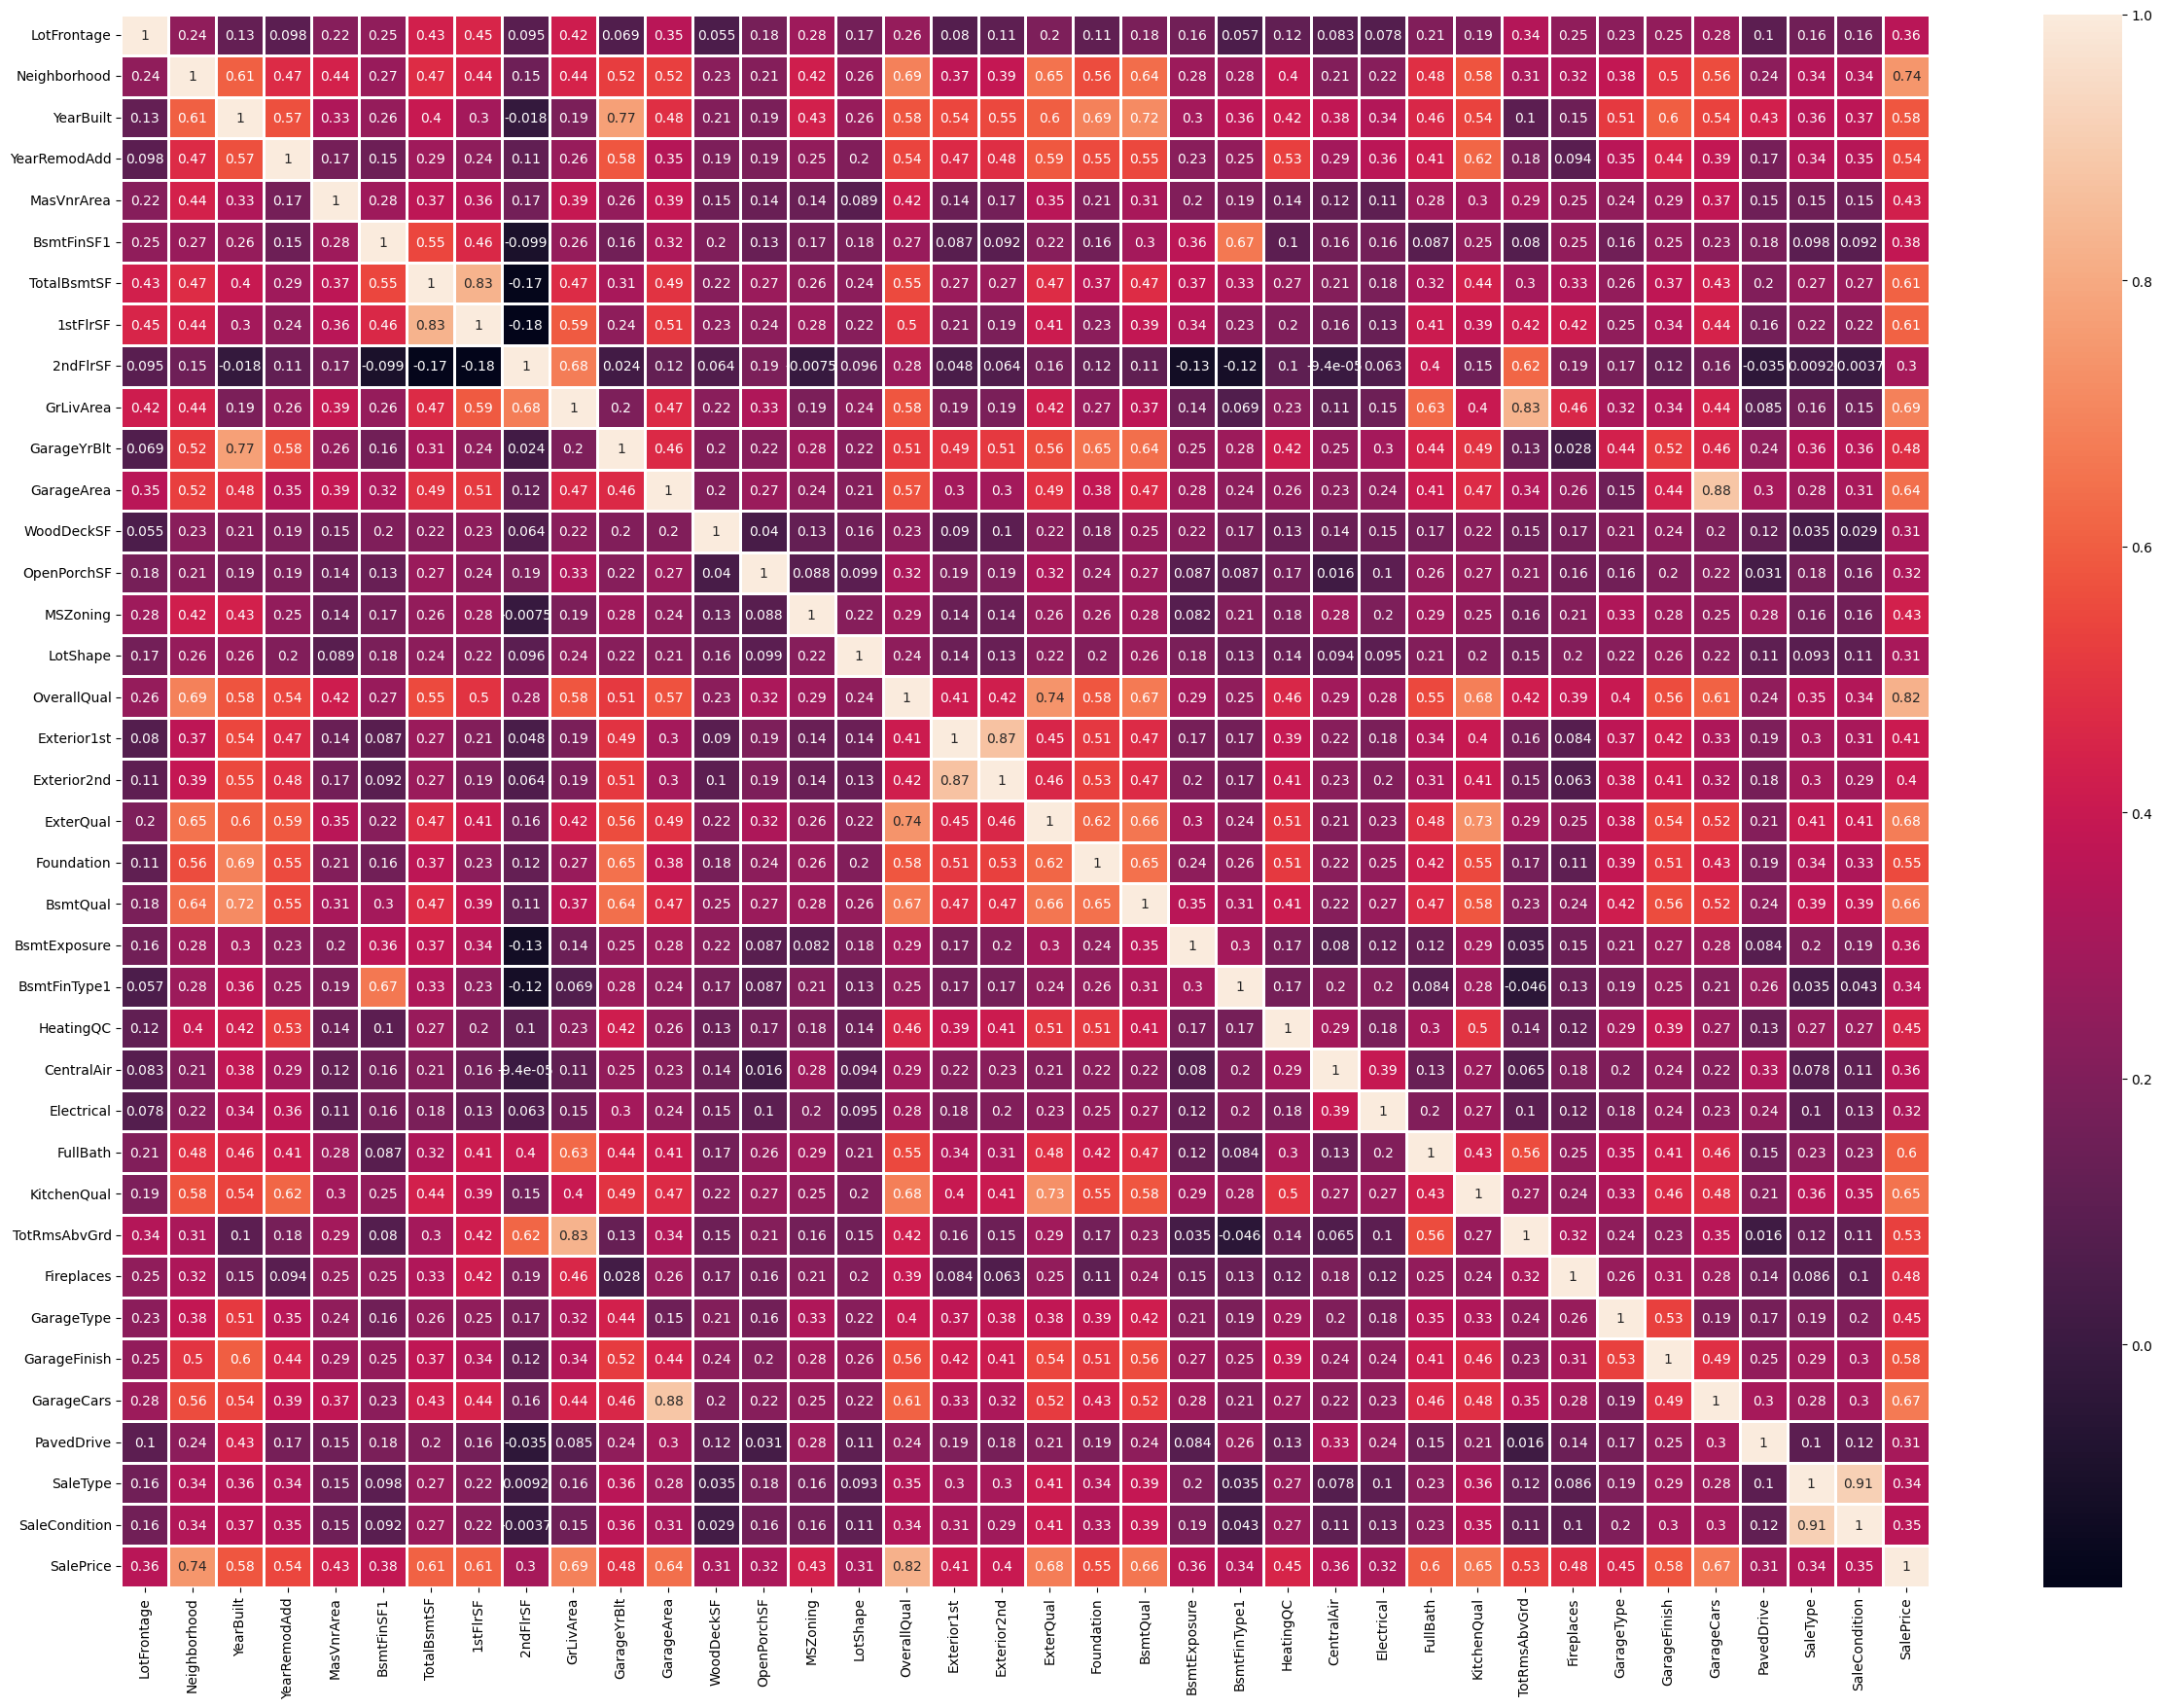

In [ ]:
# df without negligible columns
df = X_train.copy()
df['SalePrice'] = y_train

# Heatmap
plt.figure(figsize=(30,21))
sns.heatmap(df.corr(),annot=True,linewidths=2)

In [ ]:
num_columns = X_train.shape[1]
print(f"Number of columns: {num_columns}")

Number of columns: 37


The number of features reduce from 73 to 37

# Choosing Ensemble Learning Model

In [ ]:
from sklearn.linear_model import LinearRegression # baseline model
from sklearn.tree import DecisionTreeRegressor # baseline model
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor # Ensemble Learning type Bagging
from sklearn.ensemble import GradientBoostingRegressor # Ensemble Learning type Boosting
from xgboost import XGBRegressor # Ensemble Learning type Boosting

from sklearn.metrics import (r2_score,mean_absolute_error,mean_squared_error)

In [ ]:
#==== Set Up model ====
xgb = XGBRegressor(random_state=42)
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
ext = ExtraTreesRegressor(random_state=42)
linear = LinearRegression()

In [ ]:
# Rejoining the data train and test
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
# Data will be split to train and test in training model iteration to make sure the randomness of data that pick as train and test.

In [ ]:
# Iterate model
ml = [('Linear Regression',linear),
      ('Decission Trees',dt),
         ('Random Forest',rf),
         ('Extra Trees',ext),
         ("Gradient Boosting",gb),
         ('Xgboost',xgb)]

r2_train = []
r2_test = []
mae_train = []
mae_test = []
mse_train = []
mse_test = []
rmse_train = []
rmse_test = []
models = []

# For each model, it iterate 11 times to found the distribution of performance between random data
for model in ml:
  for x in range(0,11):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3)
    model[1].fit(X_train,y_train)

    predict_train = model[1].predict(X_train)
    predict_test = model[1].predict(X_test)

    r2_score_train = r2_score(y_train,predict_train)
    r2_score_test = r2_score(y_test,predict_test)

    mae_score_train = mean_absolute_error(y_train,predict_train)
    mae_score_test = mean_absolute_error(y_test,predict_test)

    mse_score_train = mean_squared_error(y_train,predict_train)
    mse_score_test = mean_squared_error(y_test,predict_test)

    rmse_score_train = np.sqrt(mse_score_train)
    rmse_score_test = np.sqrt(mse_score_test)

    r2_train.append(r2_score_train)
    r2_test.append(r2_score_test)
    mae_train.append(mae_score_train)
    mae_test.append(mae_score_test)
    mse_train.append(mse_score_train)
    mse_test.append(mse_score_test)
    rmse_train.append(rmse_score_train)
    rmse_test.append(rmse_score_test)
    models.append(model[0])


df_metrics = pd.DataFrame({'model':models,
                           'r2_score_train':r2_train,
                           'r2_score_test':r2_test,
                           'MAE_train':mae_train,
                           'MAE_test':mae_test,
                           'MSE_train':mse_train,
                           'MSE_test':mse_test,
                           'RMSE_train':rmse_train,
                           'RMSE_test':rmse_test})

In [ ]:
df_metrics

,model,r2_score_train,r2_score_test,MAE_train,MAE_test,MSE_train,MSE_test,RMSE_train,RMSE_test
0,Linear Regression,0.870630,0.889943,0.098591,0.101587,0.020380,0.018024,0.142758,0.134252
1,Linear Regression,0.869698,0.890468,0.099163,0.101777,0.020797,0.017367,0.144211,0.131785
2,Linear Regression,0.870656,0.884034,0.096547,0.102785,0.019718,0.020385,0.140419,0.142777
3,Linear Regression,0.883157,0.857069,0.097622,0.095932,0.019568,0.020063,0.139886,0.141643
4,Linear Regression,0.859084,0.908916,0.104276,0.093248,0.022081,0.014757,0.148597,0.121477
...,...,...,...,...,...,...,...,...,...
61,Xgboost,0.999827,0.879315,0.003581,0.100573,0.000027,0.019631,0.005229,0.140110
62,Xgboost,0.999792,0.887836,0.003889,0.097919,0.000034,0.017196,0.005797,0.131132
63,Xgboost,0.999844,0.869651,0.003381,0.101503,0.000025,0.019937,0.005025,0.141197
64,Xgboost,0.999771,0.861966,0.004191,0.100771,0.000038,0.019861,0.006157,0.140928


In [ ]:
#visualize
train_metrics = [x for x in df_metrics.columns if '_train' in x]
test_metrics = [x for x in df_metrics.columns if '_test' in x]

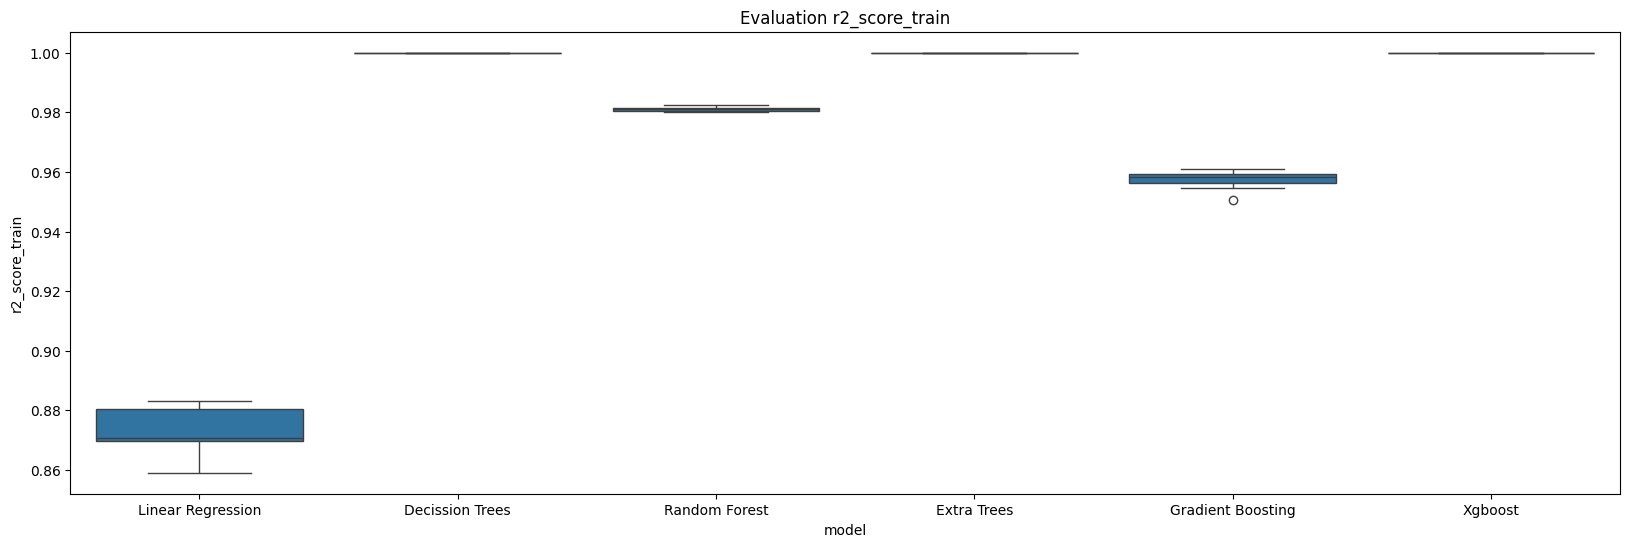

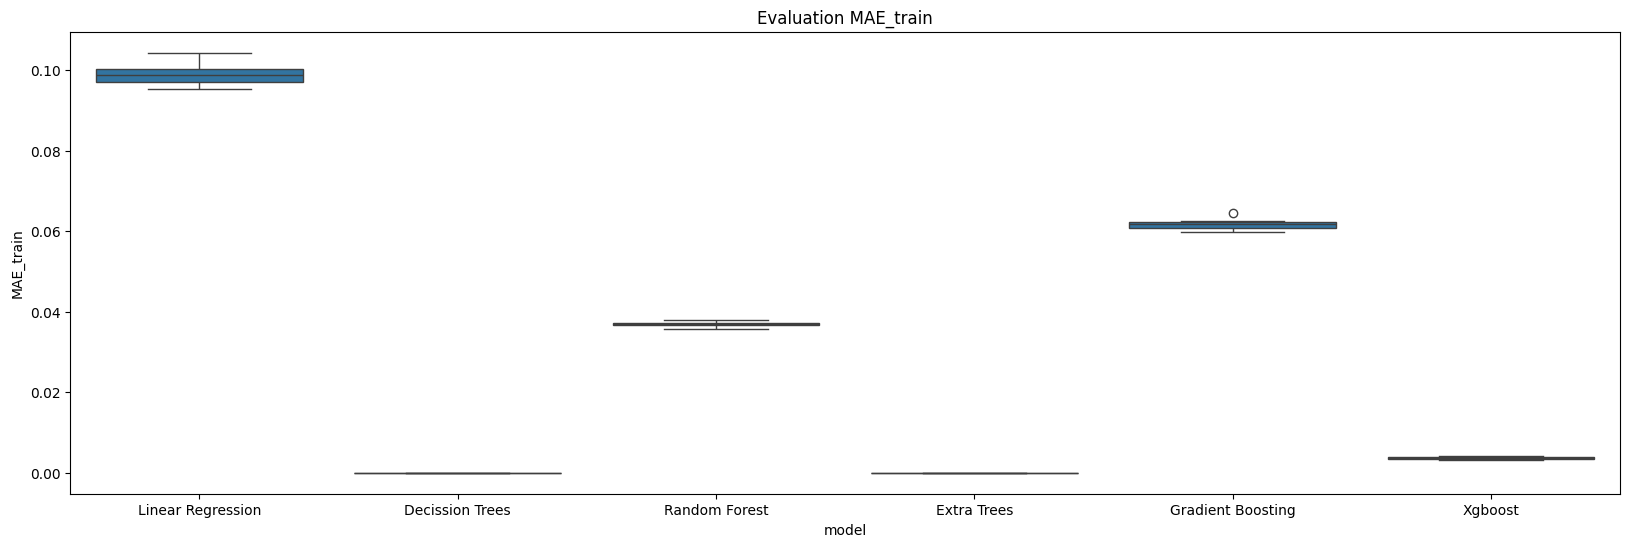

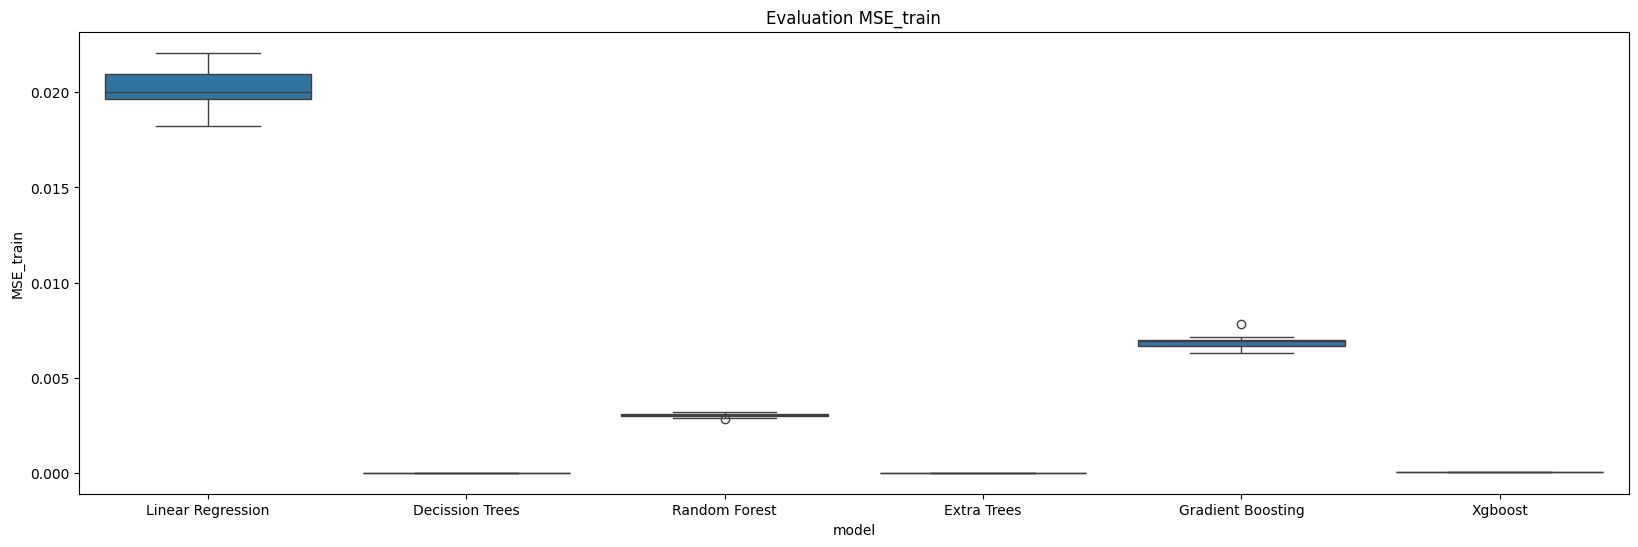

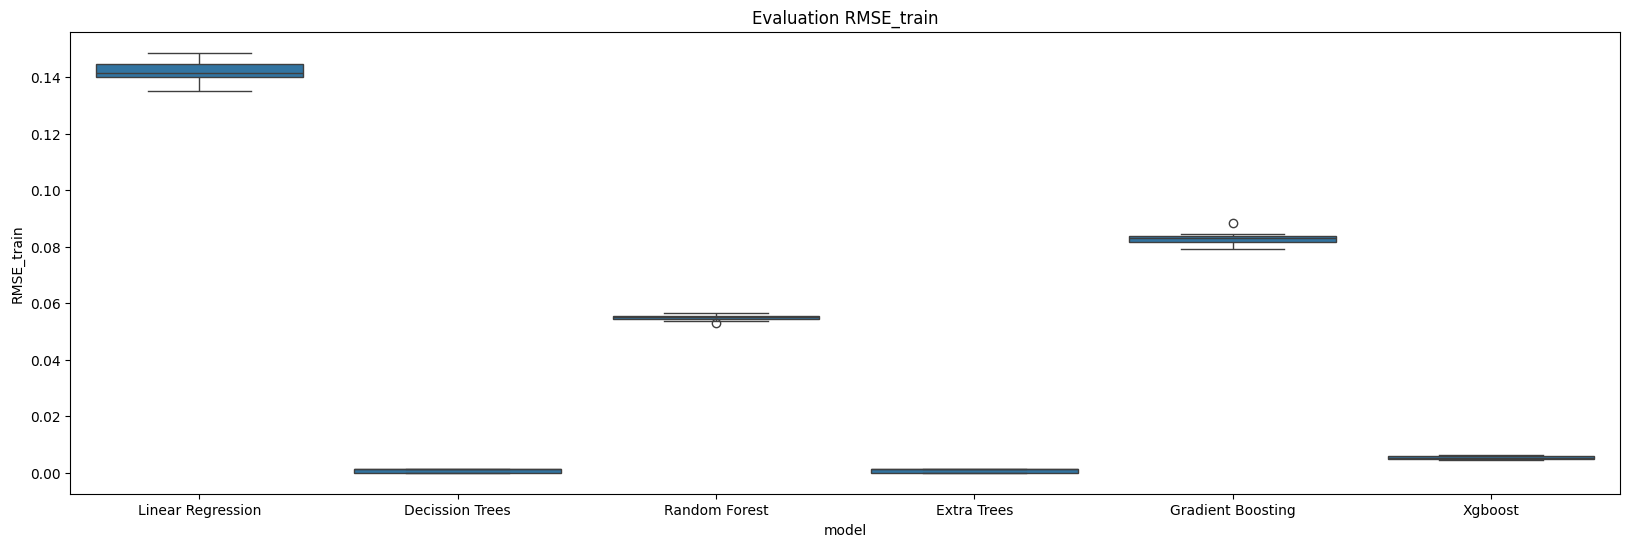

In [ ]:
for train in train_metrics:
  plt.figure(figsize=(20,6))
  sns.boxplot(data=df_metrics,x='model',y=train)
  plt.title(f"Evaluation {train}")
  plt.show()

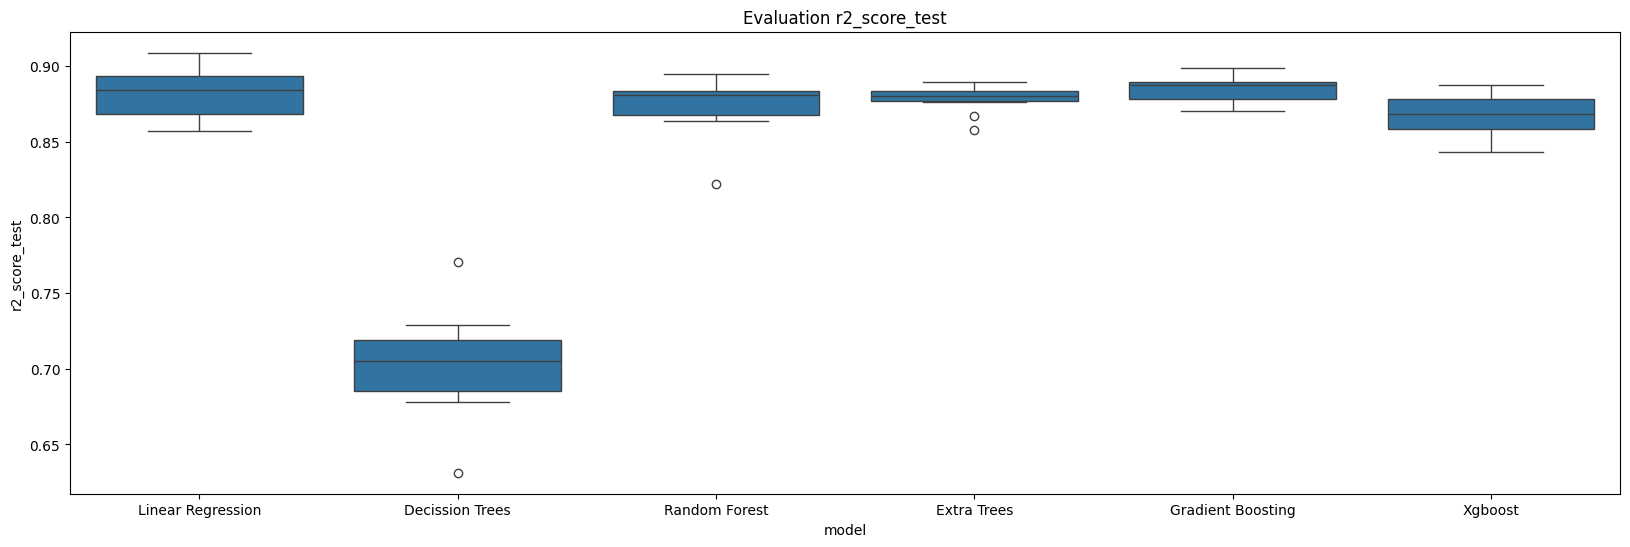

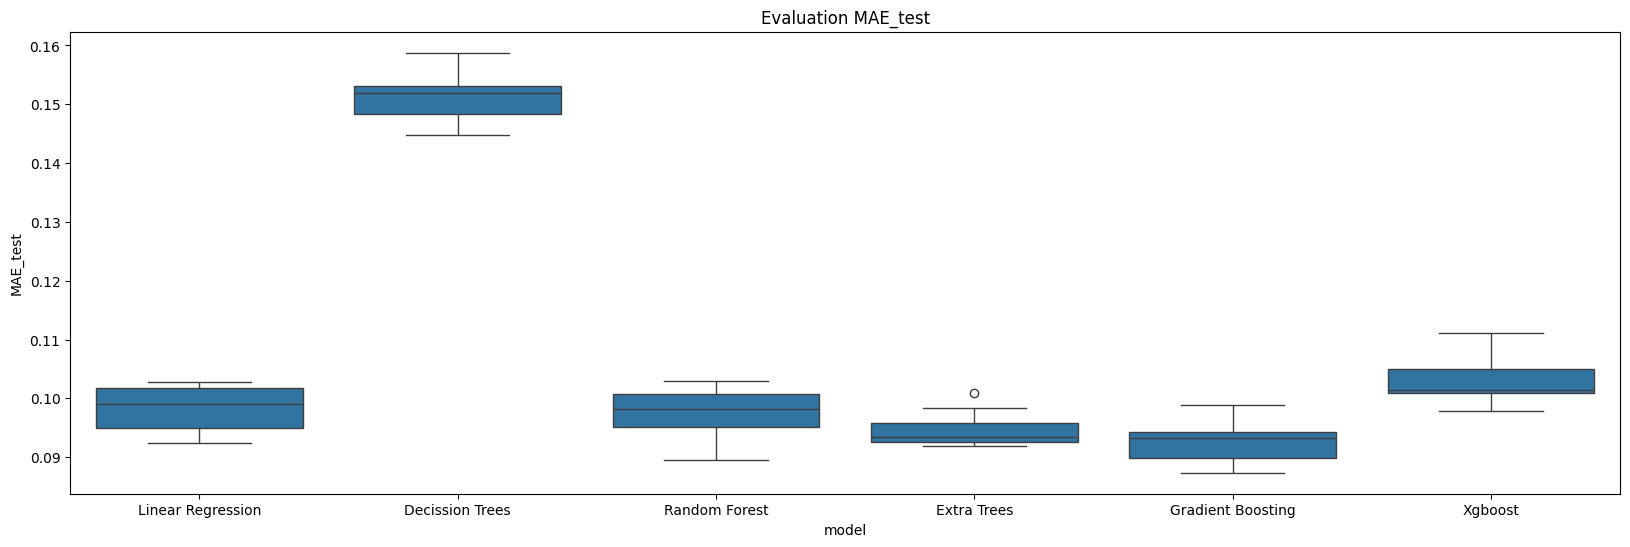

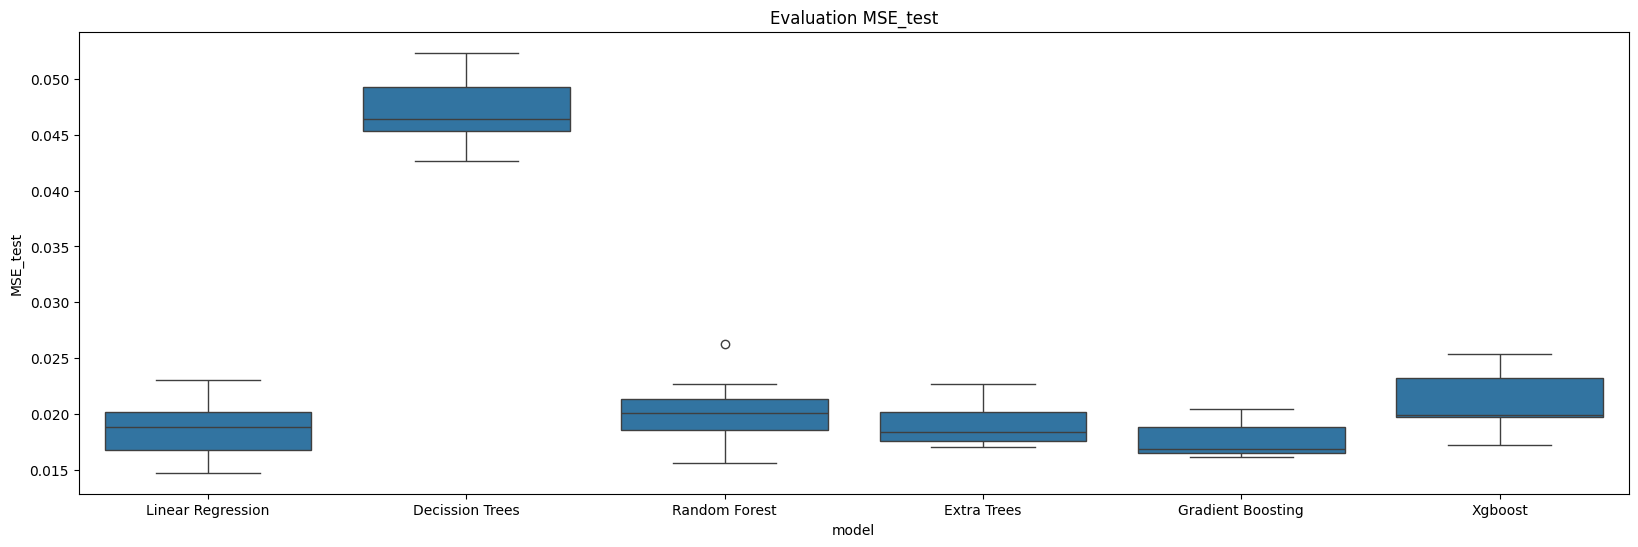

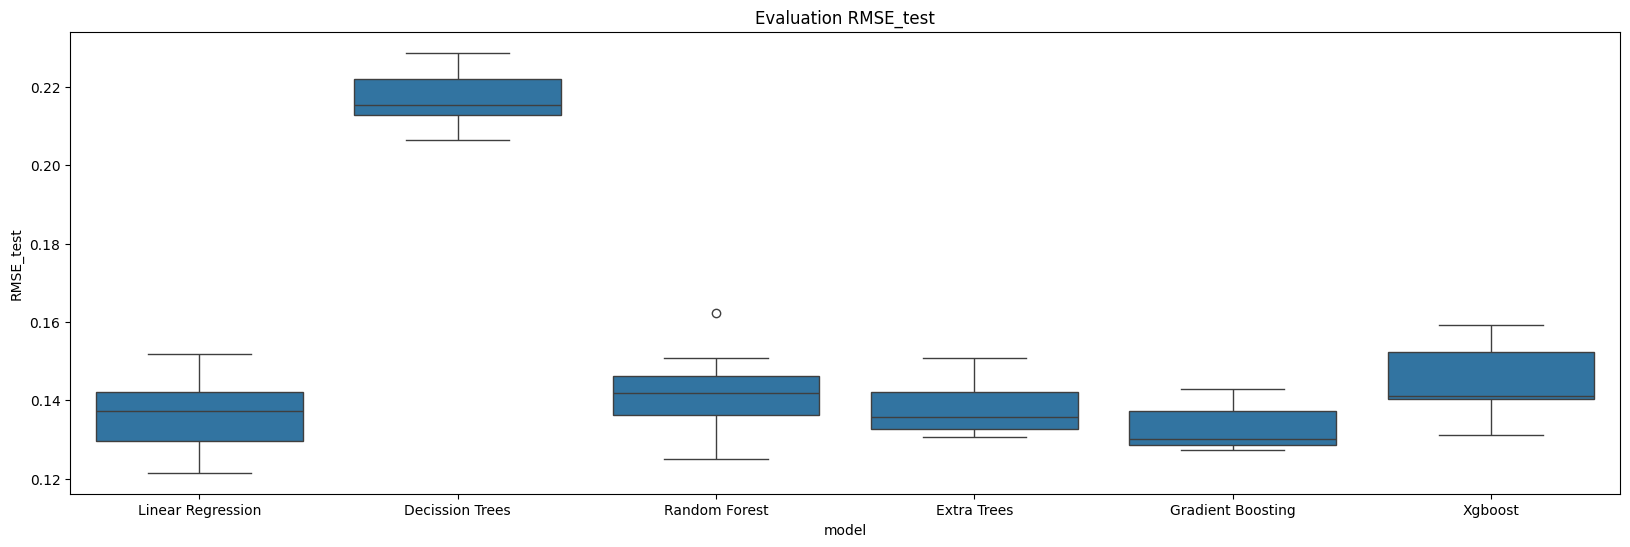

In [ ]:
for test in test_metrics:
  plt.figure(figsize=(20,6))
  sns.boxplot(data=df_metrics,x='model',y=test)
  plt.title(f"Evaluation {test}")
  plt.show()

Based on R2 test, best two model are ExtraTreesRegressor (Bagging), and GradientBoostingRegressor (Boosting). Therefore, we gonna hyperparameter tuning these two model to reduce overfitting and increase its performance. In the end, we gonna compare the fine-tuned models.

# Hyperparameter Tuning

## Extra Trees Regressor Tuning

In [ ]:
#create train and testing
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

### Base Extra Trees Regressor (without tuning)

In [ ]:
ext = ExtraTreesRegressor(random_state=42)
ext.fit(X_train,y_train)


predict_train = ext.predict(X_train)
predict_test = ext.predict(X_test)

r2_score_train = r2_score(y_train,predict_train)
r2_score_test = r2_score(y_test,predict_test)

mae_score_train = mean_absolute_error(np.exp(y_train), np.exp(predict_train))
mae_score_test = mean_absolute_error(np.exp(y_test),np.exp(predict_test))

mse_score_train = mean_squared_error(np.exp(y_train), np.exp(predict_train))
mse_score_test = mean_squared_error(np.exp(y_test),np.exp(predict_test))

rmse_score_train = np.sqrt(mse_score_train)
rmse_score_test = np.sqrt(mse_score_test)

difference_metrics = abs((rmse_score_train - rmse_score_test) / rmse_score_test) * 100
difference_metrics = round(difference_metrics, 2)

print("=====R^2 Score=====")
print('r2 score train',r2_score_train)
print('r2 score test',r2_score_test)
print("\n=====MAE=====")
print('MAE train',mae_score_train)
print('MAE test',mae_score_test)
print("\n=====RMSE=====")
print('RMSE train',rmse_score_train)
print('RMSE test',rmse_score_test)
print('Difference in RMSE (%)', difference_metrics)

=====R^2 Score=====
r2 score train 0.9999905617225471
r2 score test 0.8770094183602399

=====MAE=====
MAE train 7.338551861335709
MAE test 17228.0256045217

=====RMSE=====
RMSE train 165.90653949246095
RMSE test 31747.997599307066
Difference in RMSE (%) 99.48


Extra Trees show a very high overfitting.

### Pipe Line

Finding the best parameter tuning range to optimize Optuna search.

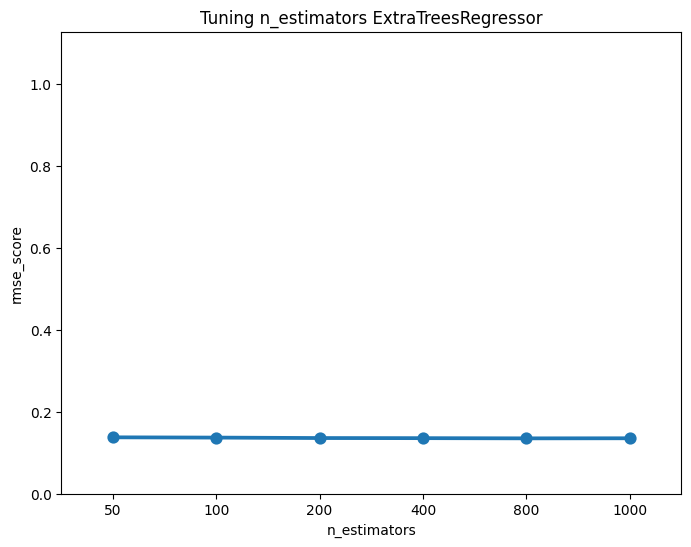

In [ ]:
n_estimators = []
rmse_score = []

for estimator in [50, 100, 200, 400, 800,1000]:
  ext = ExtraTreesRegressor(n_estimators=estimator).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  n_estimators.append(estimator)


#create dataset
df_estimator = pd.DataFrame({'n_estimators':n_estimators,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_estimator,x='n_estimators',y='rmse_score')
plt.title('Tuning n_estimators ExtraTreesRegressor')
plt.ylim(0,max(df_estimator['rmse_score'])+0.99)
plt.show()

n_estimator is less relevant to the model

n_estimators = 100 (default)

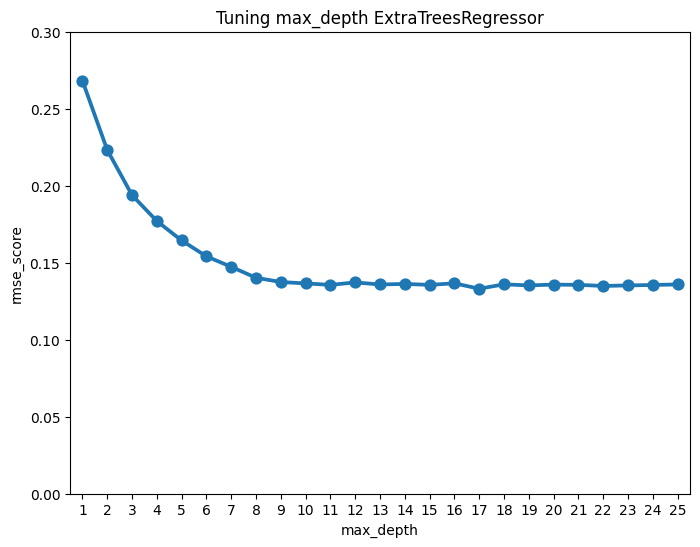

In [ ]:
max_depth = []
rmse_score = []

for depth in range(1,26):
  ext = ExtraTreesRegressor(max_depth=depth,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  max_depth.append(depth)


#create dataset
df_max_depth = pd.DataFrame({'max_depth':max_depth,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_depth,x='max_depth',y='rmse_score')
plt.title('Tuning max_depth ExtraTreesRegressor')
plt.ylim(0,0.3)
plt.show()

best max_depth = 17

for optuna training, the range are: 16-20

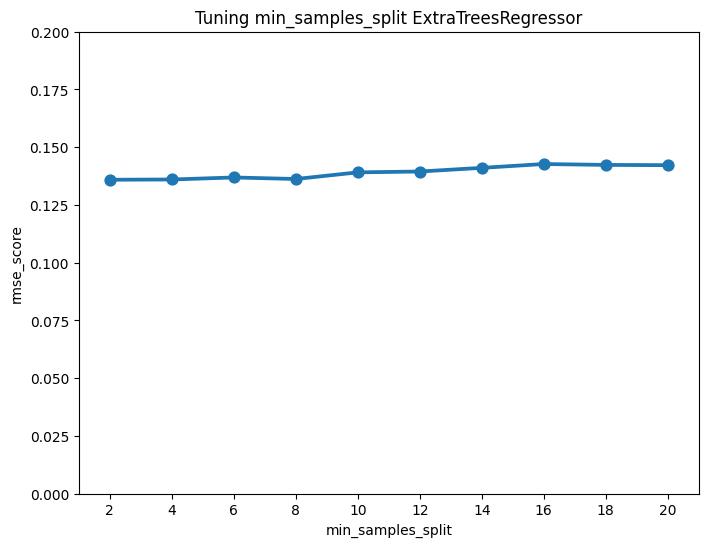

In [ ]:
min_samples_split = []
rmse_score = []

for split in range(2, 21, 2):
  ext = ExtraTreesRegressor(min_samples_split=split,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  min_samples_split.append(split)


#create dataset
df_min_samples_split = pd.DataFrame({'min_samples_split':min_samples_split,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_min_samples_split,x='min_samples_split',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning min_samples_split ExtraTreesRegressor')
plt.show()

for optuna training, the range are: 2 - 10

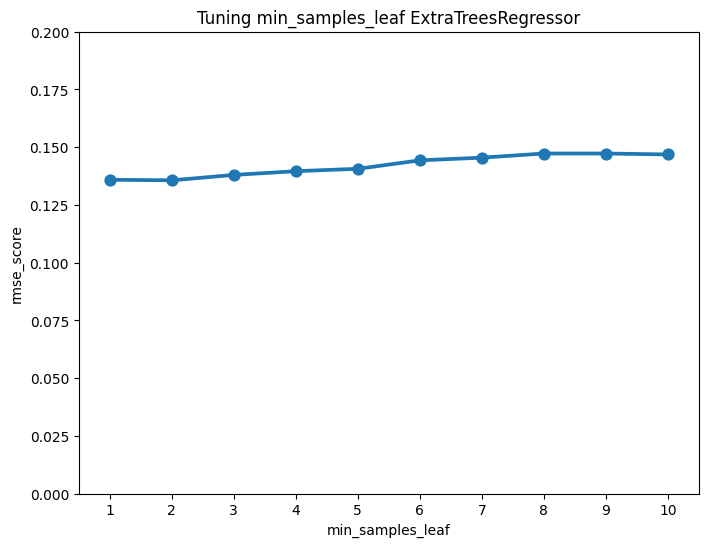

In [ ]:
min_samples_leaf = []
rmse_score = []

for leaf in range(1, 11):
  ext = ExtraTreesRegressor(min_samples_leaf=leaf,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  min_samples_leaf.append(leaf)


#create dataset
df_min_samples_leaf = pd.DataFrame({'min_samples_leaf':min_samples_leaf,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_min_samples_leaf,x='min_samples_leaf',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning min_samples_leaf ExtraTreesRegressor')
plt.show()

for optuna training, the range are 1-3

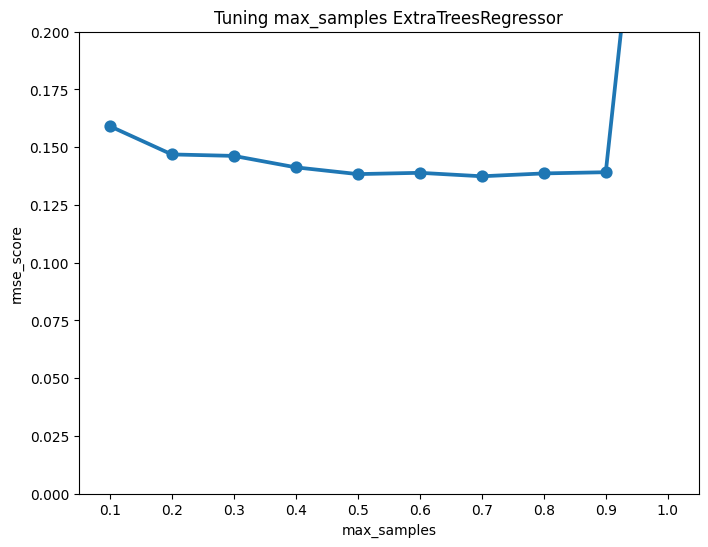

In [ ]:
max_samples = []
rmse_score = []

for sub in [0.1, 0.2,0.3,0.4,0.5,0.6, 0.7, 0.8, 0.9, 1]:
  ext = ExtraTreesRegressor(bootstrap = True, max_samples=sub,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  max_samples.append(sub)


#create dataset
df_max_samples = pd.DataFrame({'max_samples':max_samples,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_samples,x='max_samples',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning max_samples ExtraTreesRegressor')
plt.show()

for optuna training, the range are 0.8-0.9

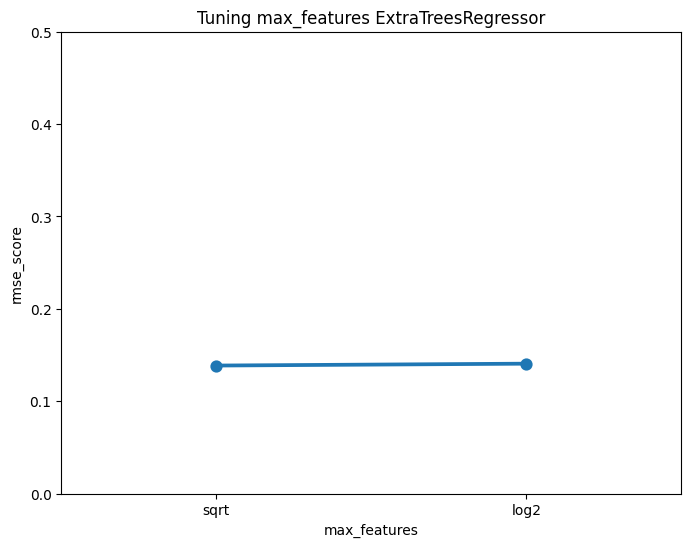

In [ ]:
max_features = []
rmse_score = []

for feature in ['sqrt', 'log2', None]:
  ext = ExtraTreesRegressor(max_features=feature,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  max_features.append(feature)


#create dataset
df_max_features = pd.DataFrame({'max_features':max_features,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_features,x='max_features',y='rmse_score')
plt.ylim([0,0.5])
plt.title('Tuning max_features ExtraTreesRegressor')
plt.show()

Max_features shows no differences, but we let optuna select the best from ['sqrt', 'log2', None]

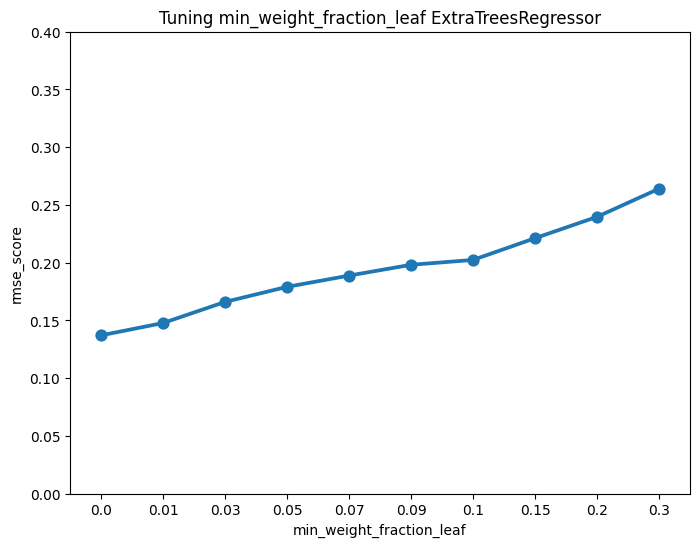

In [ ]:
min_weight_fraction_leaf = []
rmse_score = []

for weight in [0,0.01,0.03,0.05,0.07,0.09,0.1,0.15, 0.2, 0.3]:
  ext = ExtraTreesRegressor(bootstrap = True, min_weight_fraction_leaf=weight,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,ext.predict(X_test)))
  rmse_score.append(rmse)
  min_weight_fraction_leaf.append(weight)


#create dataset
df_min_weight_fraction_leaf = pd.DataFrame({'min_weight_fraction_leaf':min_weight_fraction_leaf,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_min_weight_fraction_leaf,x='min_weight_fraction_leaf',y='rmse_score')
plt.ylim([0,0.4])
plt.title('Tuning min_weight_fraction_leaf ExtraTreesRegressor')
plt.show()

min_weight_fraction_leaf = 0 (default)

so, we left it with default setting

### Optuna

Optuna Range (Extra Trees Regressor):

- n_estimators = 100

- max_depth = 16 - 20

- min_samples_split = 2 - 10

- min_samples_leaf = 1 - 3

- max_samples = 0.8 - 0.9

- max_features = ['sqrt', 'log2', None]

- min_weight_fraction_leaf = 0 (default)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to be tuned
    max_depth = trial.suggest_int('max_depth', 16, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
    max_samples = trial.suggest_float('max_samples', 0.8, 0.9)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])


    # Initialize the ExtraTreesRegressor with trial parameters
    ext = ExtraTreesRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        bootstrap=True,
        max_samples=max_samples,
        max_features=max_features,
    )

   # Perform cross-validation with the ExtraTreesRegressor model
    cv_scores = cross_val_score(ext, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean squared error
    mean_mse = -cv_scores.mean()  # Take the negative of the mean squared error

    return mean_mse

# Set up the Optuna study
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)  # We want to minimize RMSE
study.optimize(objective, n_trials=100)  # Number of trials to perform

# Get the best parameters and model
best_params = study.best_params
best_rmse = study.best_value

# Train the best model with the best parameters
best_ext = ExtraTreesRegressor(**best_params, random_state=42, bootstrap = True)
best_ext.fit(X_train, y_train)

# Make predictions and evaluate the best model
ext_pred_train = best_ext.predict(X_train)
ext_pred_test = best_ext.predict(X_test)

ext_r2_score_train = round(r2_score(y_train, ext_pred_train),3)
ext_r2_score_test = round(r2_score(y_test, ext_pred_test),3)
ext_mae_train = mean_absolute_error(np.exp(y_train), np.exp(ext_pred_train))
ext_mae_test = mean_absolute_error(np.exp(y_test), np.exp(ext_pred_test))
ext_rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(ext_pred_train)))
ext_rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(ext_pred_test)))
ext_difference_metrics = abs((ext_rmse_train - ext_rmse_test) / ext_rmse_test) * 100
ext_difference_metrics = round(ext_difference_metrics,2)

print("Best Parameters:", best_params)

[I 2025-06-12 15:49:34,638] A new study created in memory with name: no-name-2a375ff3-52b3-43d9-9c16-196f41d3049c
[I 2025-06-12 15:49:35,519] Trial 0 finished with value: 0.023532448946312554 and parameters: {'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_samples': 0.8398421759384376, 'max_features': 'log2'}. Best is trial 0 with value: 0.023532448946312554.
[I 2025-06-12 15:49:36,360] Trial 1 finished with value: 0.024624567080213856 and parameters: {'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_samples': 0.839022957009151, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.023532448946312554.
[I 2025-06-12 15:49:37,108] Trial 2 finished with value: 0.027130512214722367 and parameters: {'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_samples': 0.8098966811408994, 'max_features': 'log2'}. Best is trial 0 with value: 0.023532448946312554.
[I 2025-06-12 15:49:37,846] Trial 3 finished with value: 0.026393055180856384 an

Best Parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_samples': 0.8725278554163146, 'max_features': None}


In [ ]:
print('After Hyperparamater Tuning')
print("=====R^2 Score=====")
print("Training R^2 Score:", ext_r2_score_train)
print("Test R^2 Score:", ext_r2_score_test)
print("\n=====MAE=====")
print("Training MAE:", ext_mae_train)
print("Test MAE:", ext_mae_test)
print("\n=====RMSE=====")
print("Training RMSE:", ext_rmse_train)
print("Test RMSE:", ext_rmse_test)
print("Difference RMSE:", ext_difference_metrics, "%")

After Hyperparamater Tuning
=====R^2 Score=====
Training R^2 Score: 0.976
Test R^2 Score: 0.874

=====MAE=====
Training MAE: 7910.6551774642885
Test MAE: 17291.87718118124

=====RMSE=====
Training RMSE: 13241.033292295102
Test RMSE: 31699.16553711631
Difference RMSE: 58.23 %


## Gradient Boosting Regressor Tuning

### Base Gradient Boosting Regressor (without tuning)

In [ ]:
gb = GradientBoostingRegressor(random_state=42)
gb.fit(X_train,y_train)


predict_train = gb.predict(X_train)
predict_test = gb.predict(X_test)

r2_score_train = r2_score(y_train,predict_train)
r2_score_test = r2_score(y_test,predict_test)

mae_score_train = mean_absolute_error(np.exp(y_train), np.exp(predict_train))
mae_score_test = mean_absolute_error(np.exp(y_test),np.exp(predict_test))

mse_score_train = mean_squared_error(np.exp(y_train), np.exp(predict_train))
mse_score_test = mean_squared_error(np.exp(y_test),np.exp(predict_test))

rmse_score_train = np.sqrt(mse_score_train)
rmse_score_test = np.sqrt(mse_score_test)

difference_metrics = abs((rmse_score_train - rmse_score_test) / rmse_score_test) * 100
difference_metrics = round(difference_metrics, 2)

print("=====R^2 Score=====")
print('r2 score train',r2_score_train)
print('r2 score test',r2_score_test)
print("\n=====MAE=====")
print('MAE train',mae_score_train)
print('MAE test',mae_score_test)
print("\n=====RMSE=====")
print('RMSE train',rmse_score_train)
print('RMSE test',rmse_score_test)
print('Difference in RMSE (%)', difference_metrics)

=====R^2 Score=====
r2 score train 0.9588236715848306
r2 score test 0.8796526295509534

=====MAE=====
MAE train 10899.577342408631
MAE test 17158.3514478974

=====RMSE=====
RMSE train 14993.65216330808
RMSE test 32807.62565283342
Difference in RMSE (%) 54.3


### Pipe Line

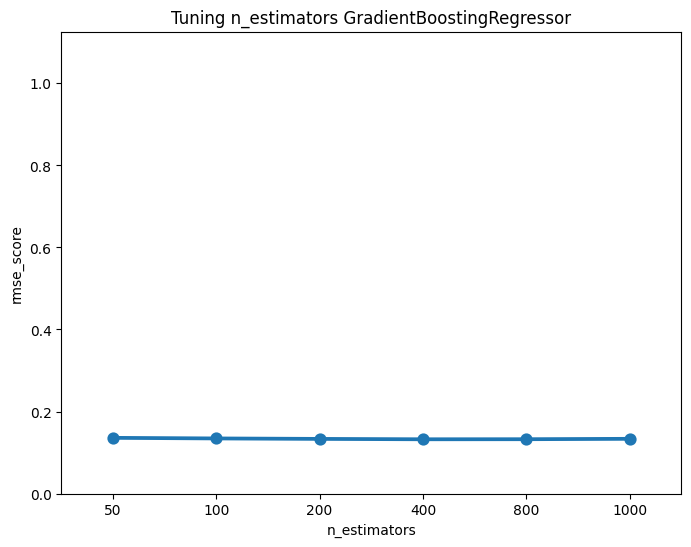

In [ ]:
n_estimators = []
rmse_score = []

for estimator in [50, 100, 200, 400, 800,1000]:
  gb = GradientBoostingRegressor(n_estimators=estimator).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  n_estimators.append(estimator)


#create dataset
df_estimator = pd.DataFrame({'n_estimators':n_estimators,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_estimator,x='n_estimators',y='rmse_score')
plt.title('Tuning n_estimators GradientBoostingRegressor')
plt.ylim(0,max(df_estimator['rmse_score'])+0.99)
plt.show()

n_estimators = 100 (default)

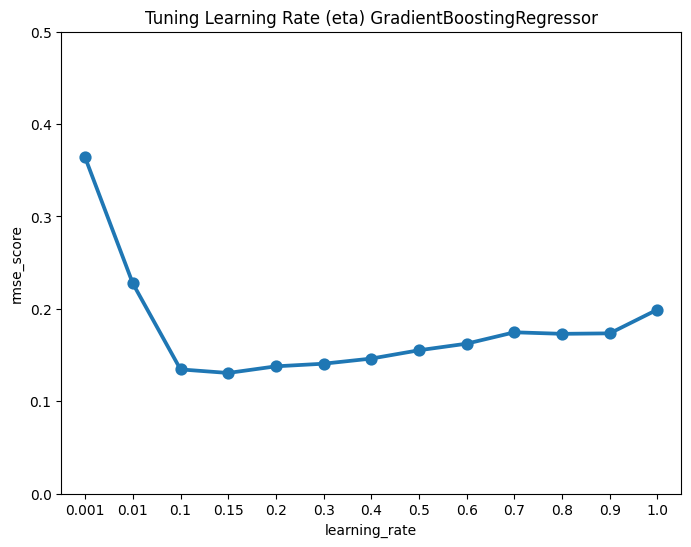

In [ ]:
learning_rate_list = [0.001,0.01,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]

learning_rate = []
rmse_score = []


for eta in learning_rate_list:
  gb = GradientBoostingRegressor(learning_rate=eta,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  learning_rate.append(eta)


#create dataset
df_eta = pd.DataFrame({'learning_rate':learning_rate,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_eta,x='learning_rate',y='rmse_score')
plt.title('Tuning Learning Rate (eta) GradientBoostingRegressor')
plt.ylim(0,0.5)
plt.show()

for optuna training, the range are: 0.1-0.2

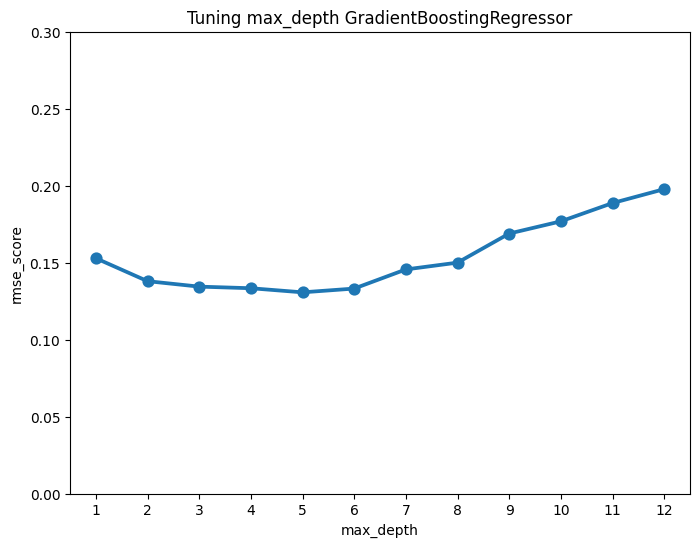

In [ ]:
max_depth = []
rmse_score = []

for depth in range(1,13):
  gb = GradientBoostingRegressor(max_depth=depth,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  max_depth.append(depth)


#create dataset
df_max_depth = pd.DataFrame({'max_depth':max_depth,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_depth,x='max_depth',y='rmse_score')
plt.title('Tuning max_depth GradientBoostingRegressor')
plt.ylim(0,0.3)
plt.show()

for optuna training, the range are: 2-6

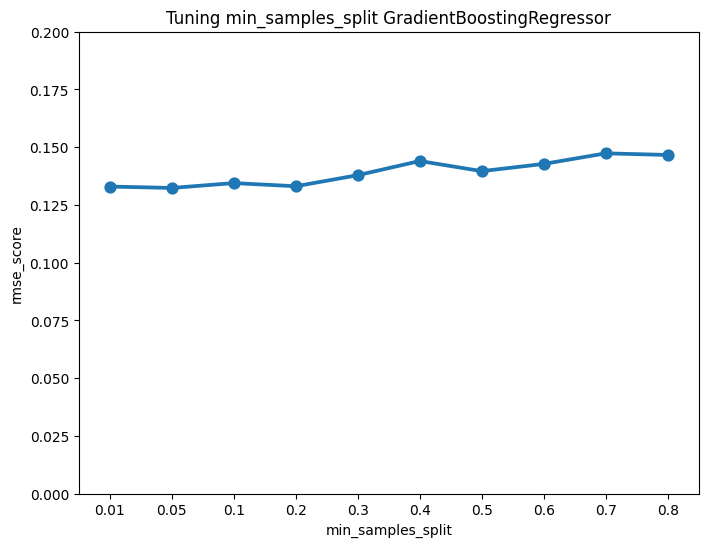

In [ ]:
min_samples_split = []
rmse_score = []

for split in [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,0.8]:
  gb = GradientBoostingRegressor(min_samples_split=split,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  min_samples_split.append(split)


#create dataset
df_min_samples_split = pd.DataFrame({'min_samples_split':min_samples_split,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_min_samples_split,x='min_samples_split',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning min_samples_split GradientBoostingRegressor')
plt.show()

for optuna training, the range are: 0.05-0.2

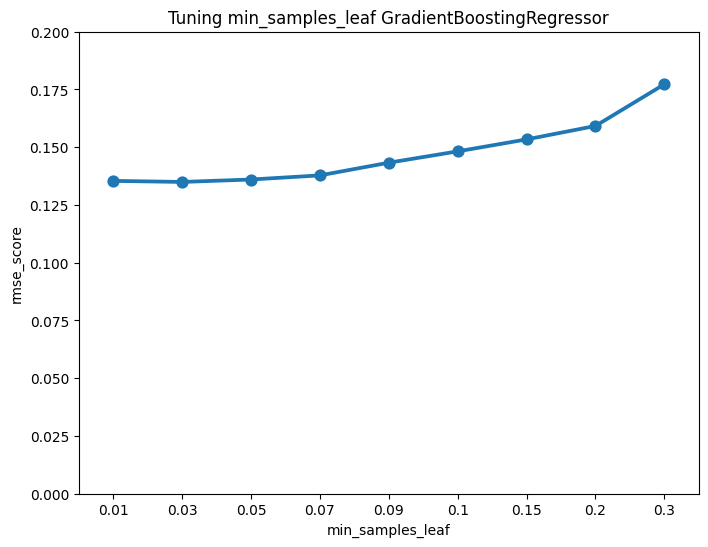

In [ ]:
min_samples_leaf = []
rmse_score = []

for leaf in [0.01,0.03,0.05,0.07,0.09,0.1,0.15, 0.2, 0.3]:
  gb = GradientBoostingRegressor(min_samples_leaf=leaf,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  min_samples_leaf.append(leaf)


#create dataset
df_min_samples_leaf = pd.DataFrame({'min_samples_leaf':min_samples_leaf,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_min_samples_leaf,x='min_samples_leaf',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning min_samples_leaf GradientBoostingRegressor')
plt.show()

for optuna training, the range are: 0.01-0.05

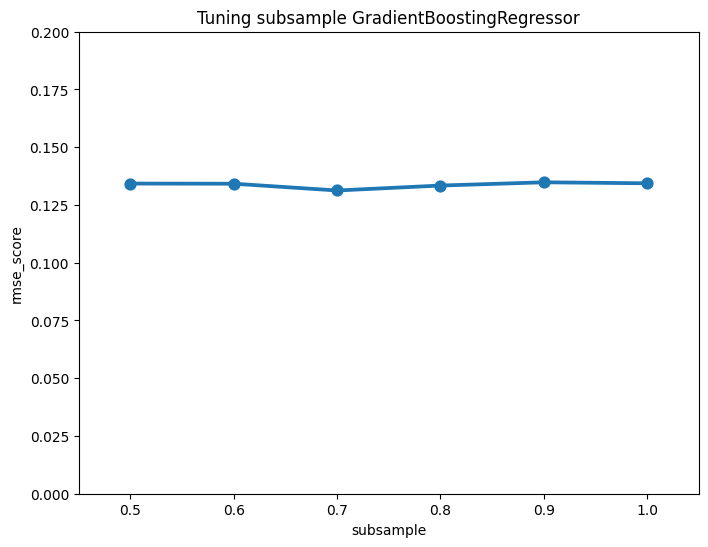

In [ ]:
subsample = []
rmse_score = []

for sub in [0.5,0.6, 0.7, 0.8, 0.9, 1]:
  gb = GradientBoostingRegressor(subsample=sub,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  subsample.append(sub)


#create dataset
df_subsample = pd.DataFrame({'subsample':subsample,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_subsample,x='subsample',y='rmse_score')
plt.ylim([0,0.2])
plt.title('Tuning subsample GradientBoostingRegressor')
plt.show()

best subsample = 0.7

for optuna training, the range are: 0.6-0.8

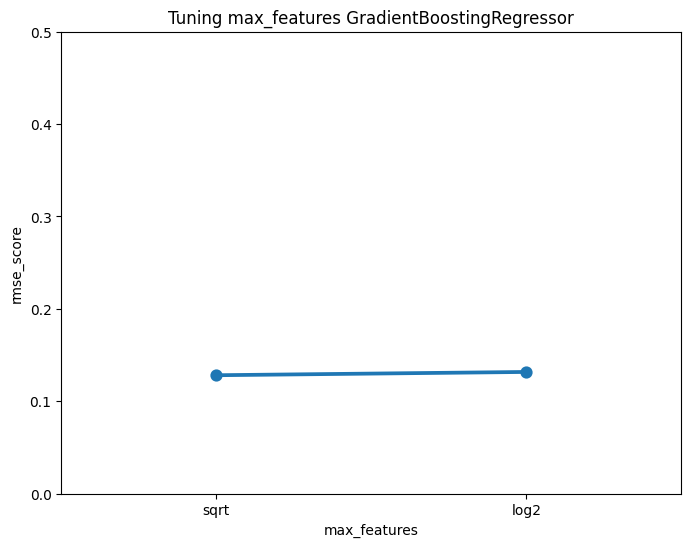

In [ ]:
max_features = []
rmse_score = []

for feature in ['sqrt', 'log2', None]:
  gb = GradientBoostingRegressor(max_features=feature,random_state=42).fit(X_train,y_train)
  rmse = np.sqrt(mean_squared_error(y_test,gb.predict(X_test)))
  rmse_score.append(rmse)
  max_features.append(feature)


#create dataset
df_max_features = pd.DataFrame({'max_features':max_features,
                       'rmse_score':rmse_score})

plt.figure(figsize=(8,6))
sns.pointplot(data=df_max_features,x='max_features',y='rmse_score')
plt.ylim([0,0.5])
plt.title('Tuning max_features GradientBoostingRegressor')
plt.show()

Max_features shows no differences, but we let optuna select the best from ['sqrt', 'log2', None]

### Optuna

Optuna Range (Gradient Boosting Regressor):

- n_estimators = 100

- max_depth = 2 - 6

- min_samples_split = 0.05 - 0.2

- min_samples_leaf = 0.01 - 0.05

- max_samples = 0.6 - 0.8

- max_features = ['sqrt', 'log2', None]

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Define hyperparameters to be tuned
    learning_rate = trial.suggest_float('learning_rate', 0.1, 0.2)
    max_depth = trial.suggest_int('max_depth', 2, 6)
    min_samples_split = trial.suggest_float('min_samples_split', 0.05, 0.2)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.01, 0.05)
    subsample = trial.suggest_float('subsample', 0.6, 0.8)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])


    # Initialize the GradientBoostingRegressor with trial parameters
    gb = GradientBoostingRegressor(
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        max_features=max_features,
    )

   # Perform cross-validation with the XGBoost model
    cv_scores = cross_val_score(gb, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

    # Calculate the mean squared error
    mean_mse = -cv_scores.mean()  # Take the negative of the mean squared error

    return mean_mse

# Set up the Optuna study
pruner = optuna.pruners.MedianPruner()
study = optuna.create_study(direction='minimize', pruner=pruner)  # We want to minimize RMSE
study.optimize(objective, n_trials=100)  # Number of trials to perform

# Get the best parameters and model
best_params = study.best_params
best_rmse = study.best_value

# Train the best model with the best parameters
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Make predictions and evaluate the best model
gb_pred_train = best_gb.predict(X_train)
gb_pred_test = best_gb.predict(X_test)

gb_r2_score_train = round(r2_score(y_train, gb_pred_train),3)
gb_r2_score_test = round(r2_score(y_test, gb_pred_test),3)
gb_mae_train = mean_absolute_error(np.exp(y_train), np.exp(gb_pred_train))
gb_mae_test = mean_absolute_error(np.exp(y_test), np.exp(gb_pred_test))
gb_rmse_train = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(gb_pred_train)))
gb_rmse_test = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(gb_pred_test)))
gb_difference_metrics = abs((gb_rmse_train - gb_rmse_test) / gb_rmse_test) * 100
gb_difference_metrics = round(gb_difference_metrics,2)

print("Best Parameters:", best_params)

[I 2025-06-12 16:09:14,138] A new study created in memory with name: no-name-fe98d505-19fb-4ddf-80e5-bf65a1e85ec3
[I 2025-06-12 16:09:16,684] Trial 0 finished with value: 0.020410055168130884 and parameters: {'learning_rate': 0.1429483943343483, 'max_depth': 3, 'min_samples_split': 0.08498773756977826, 'min_samples_leaf': 0.03623859600938291, 'subsample': 0.710815488204112, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.020410055168130884.
[I 2025-06-12 16:09:18,136] Trial 1 finished with value: 0.01938204775617895 and parameters: {'learning_rate': 0.06679336142240941, 'max_depth': 6, 'min_samples_split': 0.09364993056492785, 'min_samples_leaf': 0.013268261738987026, 'subsample': 0.7753328979493227, 'max_features': 'log2'}. Best is trial 1 with value: 0.01938204775617895.
[I 2025-06-12 16:09:20,528] Trial 2 finished with value: 0.01953122079626261 and parameters: {'learning_rate': 0.06470607926257357, 'max_depth': 6, 'min_samples_split': 0.1488297828926917, 'min_samples_leaf': 

Best Parameters: {'learning_rate': 0.06404377375487695, 'max_depth': 6, 'min_samples_split': 0.11104367985135397, 'min_samples_leaf': 0.019217918231543812, 'subsample': 0.6346935822600632, 'max_features': 'log2'}


In [ ]:
print('After Hyperparamater Tuning')
print("=====R^2 Score=====")
print("Training R^2 Score:", gb_r2_score_train)
print("Test R^2 Score:", gb_r2_score_test)
print("\n=====MAE=====")
print("Training MAE:", gb_mae_train)
print("Test MAE:", gb_mae_test)
print("\n=====RMSE=====")
print("Training RMSE:", gb_rmse_train)
print("Test RMSE:", gb_rmse_test)
print("Difference RMSE:", gb_difference_metrics, "%")

After Hyperparamater Tuning
=====R^2 Score=====
Training R^2 Score: 0.924
Test R^2 Score: 0.876

=====MAE=====
Training MAE: 13420.311207543064
Test MAE: 16985.07006672696

=====RMSE=====
Training RMSE: 22734.52600005774
Test RMSE: 32082.57980812569
Difference RMSE: 29.14 %


With Optuna optimization, overfitting in the model is reduced.

# Last Evaluation

In [ ]:
print('Extra Trees Regressor')
print("=====R^2 Score=====")
print("Training R^2 Score:", ext_r2_score_train)
print("Test R^2 Score:", ext_r2_score_test)
print("\n=====MAE=====")
print("Training MAE:", ext_mae_train)
print("Test MAE:", ext_mae_test)
print("\n=====RMSE=====")
print("Training RMSE:", ext_rmse_train)
print("Test RMSE:", ext_rmse_test)
print("Difference RMSE:", ext_difference_metrics, "%")

Extra Trees Regressor
=====R^2 Score=====
Training R^2 Score: 0.976
Test R^2 Score: 0.874

=====MAE=====
Training MAE: 7910.6551774642885
Test MAE: 17291.87718118124

=====RMSE=====
Training RMSE: 13241.033292295102
Test RMSE: 31699.16553711631
Difference RMSE: 58.23 %


In [ ]:
print('Gradient Boosting Regressor')
print("=====R^2 Score=====")
print("Training R^2 Score:", gb_r2_score_train)
print("Test R^2 Score:", gb_r2_score_test)
print("\n=====MAE=====")
print("Training MAE:", gb_mae_train)
print("Test MAE:", gb_mae_test)
print("\n=====RMSE=====")
print("Training RMSE:", gb_rmse_train)
print("Test RMSE:", gb_rmse_test)
print("Difference RMSE:", gb_difference_metrics, "%")

Gradient Boosting Regressor
=====R^2 Score=====
Training R^2 Score: 0.924
Test R^2 Score: 0.876

=====MAE=====
Training MAE: 13420.311207543064
Test MAE: 16985.07006672696

=====RMSE=====
Training RMSE: 22734.52600005774
Test RMSE: 32082.57980812569
Difference RMSE: 29.14 %


# Based on the final result, the best ensemble learning model is Gradient Boosting Regressor with R2 score of 87.6%.